#SVM-Modell

In [2]:
import pandas as pd

df = pd.read_csv('/content/Daten_kodiert_fuer_modelle_dummycodierung_V6.csv')
df.head(5)

character  \
0  Oh Joon-woo, Kim Yoo-bin, Sang-chul, Elena Kim...   
1                         Narrator, Self, Self, Self   
2  Ditto, Ayu, Darma, Mili, Dila, Rifnu, Aca, Iqb...   
3  Ditto, Ayu, Ayu's Mother, Ditto's Mother, Ditt...   
4  Dani Barnes, Cameron Drake, Alexa Medina, Fred...   

                                         description  runtime  imdb_votes  \
0  As a grisly virus rampages a city, a lone man ...     98.0     38313.0   
1  One single Anne Frank moves us more than the c...     92.0      1548.0   
2  Pining for his high school crush for years, a ...    102.0       714.0   
3  As Ayu and Ditto finally transition from best ...    104.0       311.0   
4  When nerdy high schooler Dani finally attracts...     99.0      6357.0   

                          title  animation  comedy  crime  documentation  \
0                        #Alive          0       0      0              0   
1  #AnneFrank. Parallel Stories          0       0      0              0   
2             #FriendButMarried          0       0      0              0   
3           #FriendButMarried 2          0       0      0              0   
4                  #realityhigh          0       1      0              0   

   drama  ...  Adil_Hussain  Nobunaga_Shimazaki  Manisha_Koirala  \
0      0  ...             0                   0                0   
1      1  ...             0                   0                0   
2      0  ...             0                   0                0   
3      1  ...             0                   0                0   
4      0  ...             0                   0                0   

   Ashleigh_Ball  Aoi_Yuki  Koji_Yusa  Tomokazu_Sugita  Graham_Chapman  \
0              0         0          0                0               0   
1              0         0          0                0               0   
2              0         0          0                0               0   
3              0         0          0                0               0   
4              0         0          0                0               0   

   Other_actors  target_variable  
0             1            6.550  
1             1            6.650  
2             1            6.775  
3             1            7.050  
4             1            5.425  

[5 rows x 160 columns]

In [3]:
y = df['target_variable']
X = df.drop(columns=['target_variable', 'description', 'title', 'character'])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [6]:
svm = make_pipeline(scaler, SVR())

In [7]:
svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
def evaluate(reg, X_test, y_test):
  pred = reg.predict(X_test)
  print('R2:', r2_score(y_test, pred))
  print('MAE:', mean_absolute_error(y_test, pred))
  print('MSE:', mean_squared_error(y_test, pred))
  print('RMSE:', mean_squared_error(y_test, pred, squared=False))
  print('MAPE:', mean_absolute_percentage_error(y_test, pred))

In [9]:
evaluate(svm, X_test, y_test)

R2: 0.2620107855048963
MAE: 0.6963619592857666
MSE: 0.8327652752247968
RMSE: 0.9125597378937977
MAPE: 0.11718432516235433


R^2 Wert von 0,26 -> Das Modell erklärt etwa 30% der Varianz in den beobachteten Daten. Somit dient das Modell nur moderat zur Vorhersage.

# Hyperparameter Tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV

Zunächst das Hyperparameter Raster festlegen

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV



# Definiere die Pipeline
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('svm', SVR())
])

In [12]:
# Definiere den Parameterraum für den SVR
param_grid = {
    'svm__kernel': ['linear', 'rbf', 'sigmoid'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1, 0.01, 0.001],
    'svm__epsilon': [0.1, 0.01, 0.001]
}

In [13]:
# Erstelle den RandomizedSearchCV Estimator
optimized_svm = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, n_jobs=-1, random_state=42, verbose=3)

In [14]:
# Führe das Hyperparameter-Tuning durch
optimized_svm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svm', SVR())]),
                   n_jobs=-1,
                   param_distributions={'svm__C': [0.1, 1, 10],
                                        'svm__epsilon': [0.1, 0.01, 0.001],
                                        'svm__gamma': [0.1, 0.01, 0.001],
                                        'svm__kernel': ['linear', 'rbf',
                                                        'sigmoid']},
                   random_state=42, verbose=3)

In [15]:
optimized_svm.best_params_

{'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__epsilon': 0.1, 'svm__C': 1}

In [16]:
evaluate(optimized_svm, X_test, y_test)

R2: 0.2643390042603647
MAE: 0.694742438702619
MSE: 0.8301380556196869
RMSE: 0.9111191226286972
MAPE: 0.11665073470359945


Durch Hyperparamter Tuning konnte das Modell von R^2 = 0,262 nur minimal auf 0,264 verbessert werden.

# Overfitting testen

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# get best svm model (after hyperparam tuning)
best_svm = optimized_svm.best_estimator_

# make predictions using the best svm model
predictions = best_svm.predict(X_test)

# calculate the deviance (error) for all examples in the test set
test_score = best_svm.score(X_test, y_test)

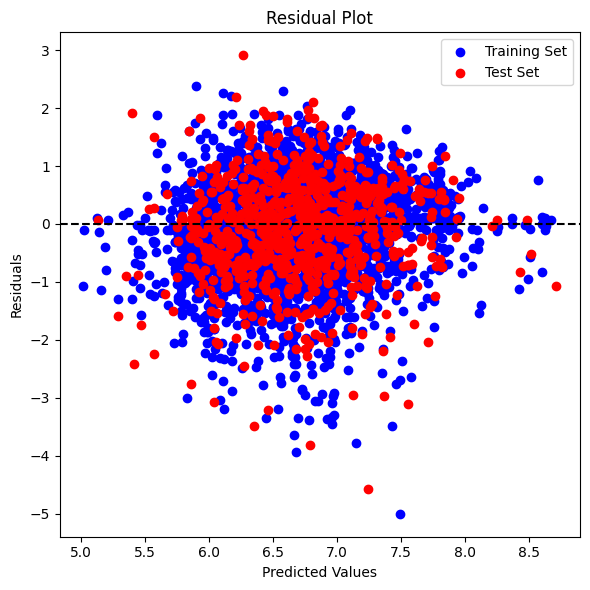

In [19]:
# Vorhersage Training
train_predictions = best_svm.predict(X_train)
# Vorhersage Test
test_predictions = best_svm.predict(X_test)

# Berechnung der Residuen
train_residuals = y_train - train_predictions
test_residuals = y_test - test_predictions

# Plot der Residuen
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.scatter(train_predictions, train_residuals, c='b', label='Training Set')
plt.scatter(test_predictions, test_residuals, c='r', label='Test Set')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

Viele Punkte orientieren sich um die Nulllinie herum. Allerdings gibt es große Ausreißer nach unten.

#Error Analysis

In [20]:
predictions = optimized_svm.predict(X_test)
df_with_predictions = pd.concat([X_test, y_test], axis='columns')
df_with_predictions = pd.concat([df_with_predictions, pd.DataFrame(predictions, columns=['Prediction'], index=df_with_predictions.index)], axis=1)

In [21]:
df_with_predictions['pred_diff'] = np.abs(df_with_predictions['target_variable'] - df_with_predictions.Prediction)

<Axes: ylabel='Frequency'>

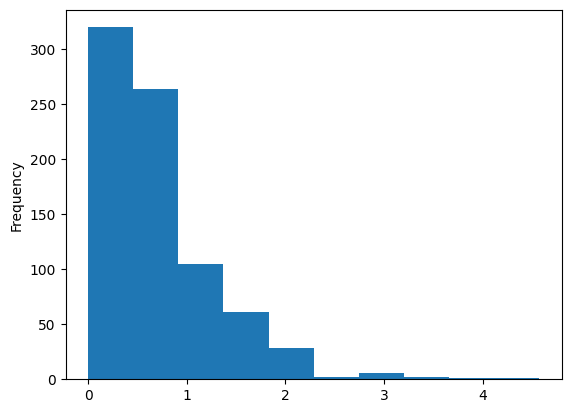

In [22]:
df_with_predictions.pred_diff.plot(kind='hist')

<ipython-input-23-0db338ff5b2b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2) # required if we want to plot multiple figures from the same cell


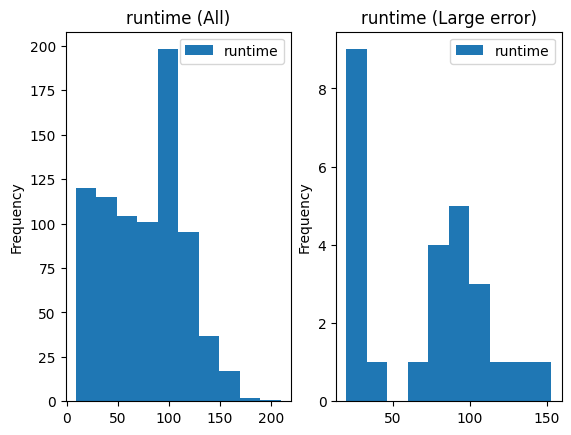

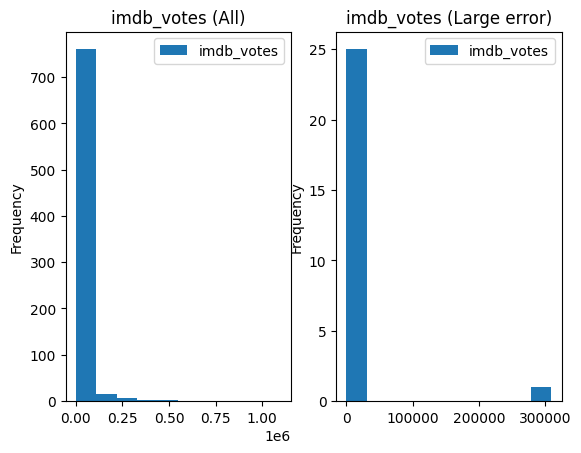

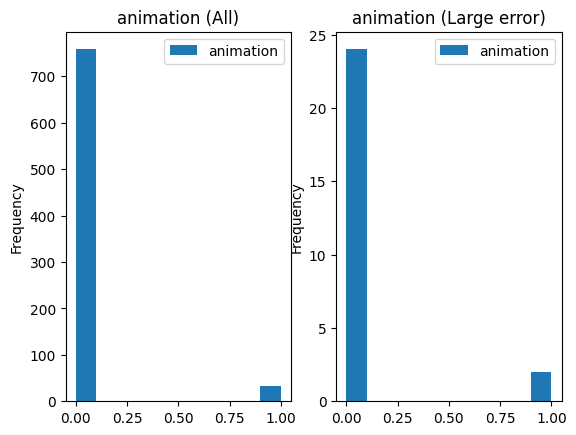

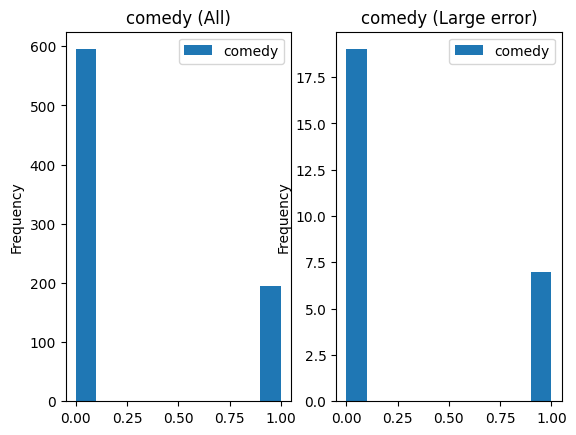

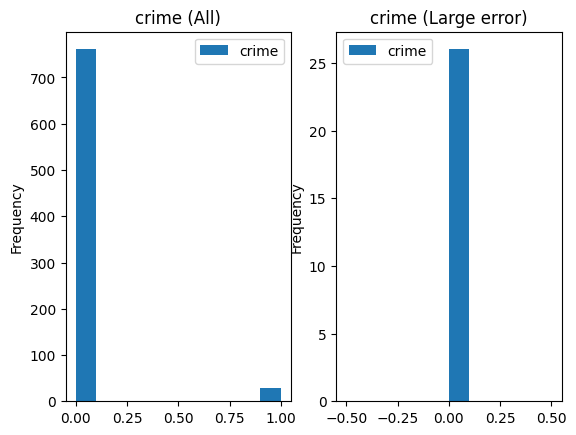

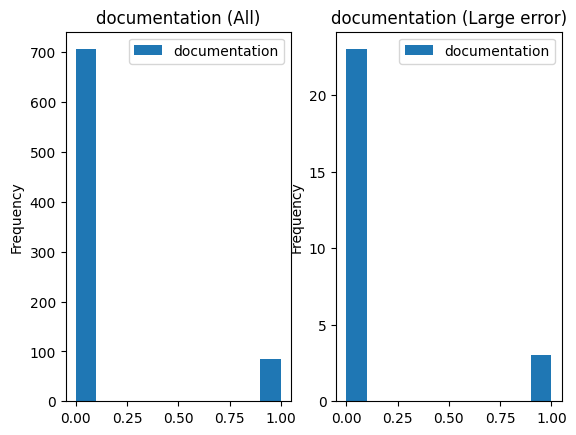

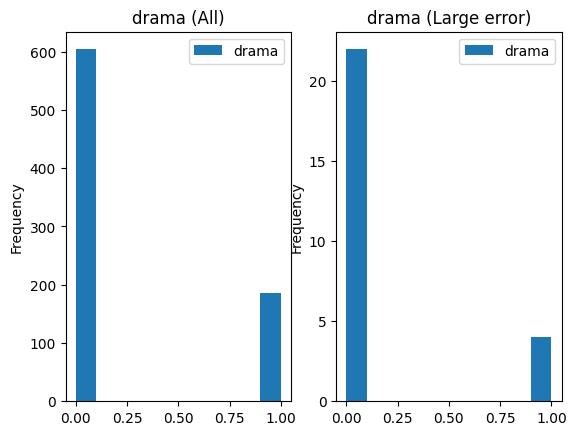

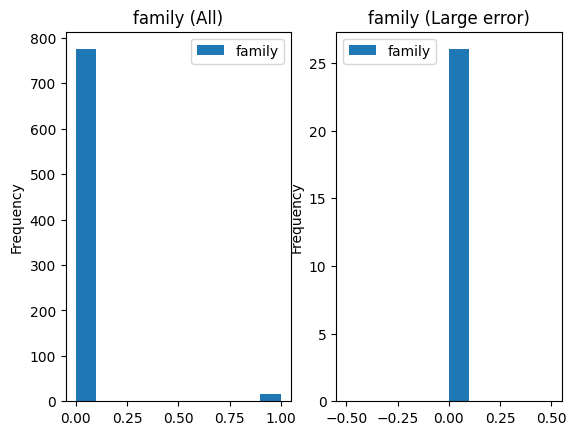

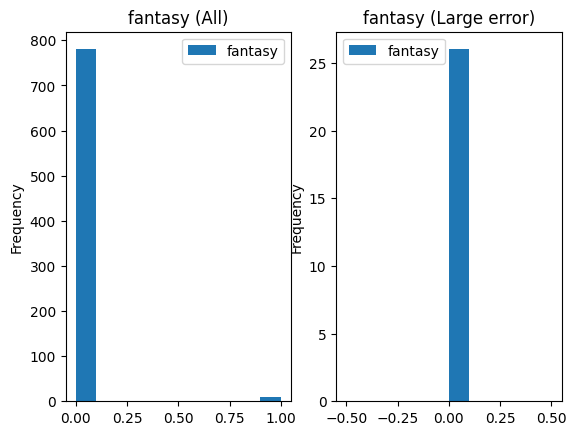

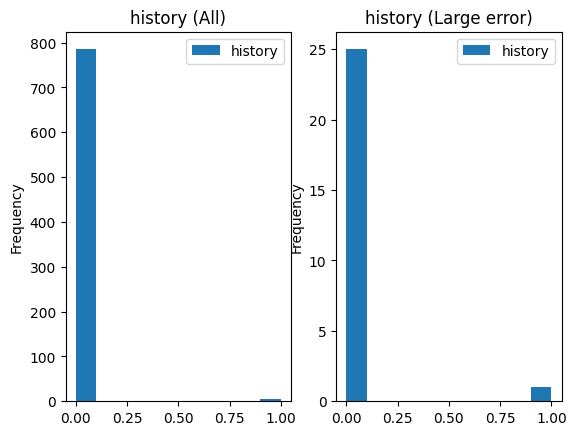

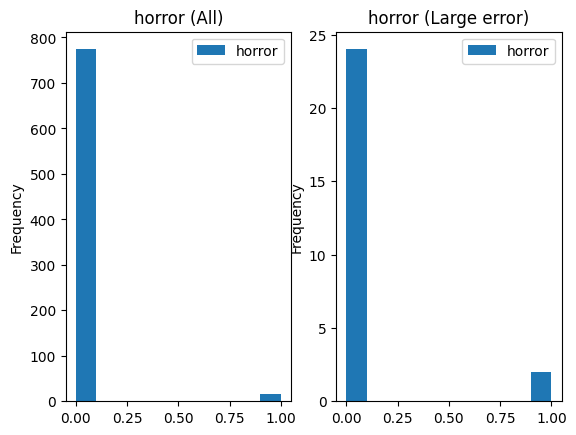

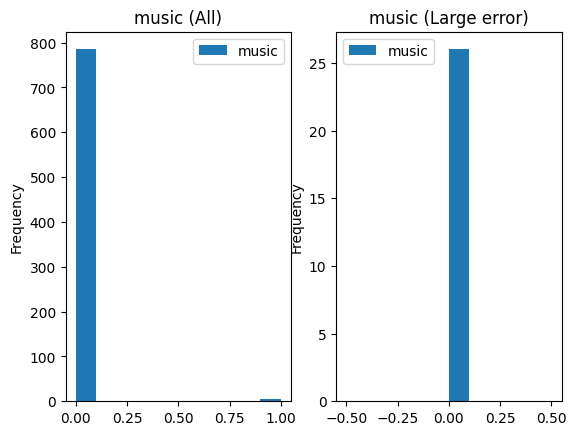

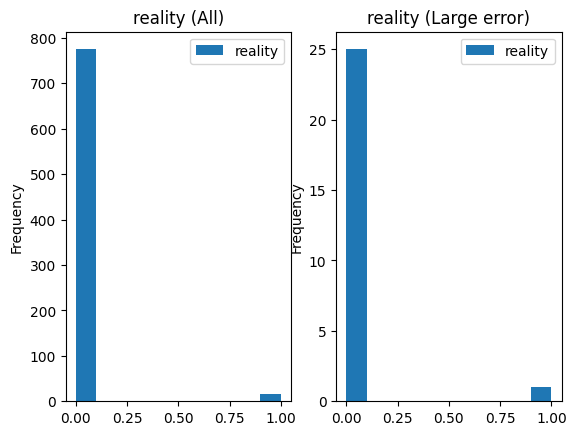

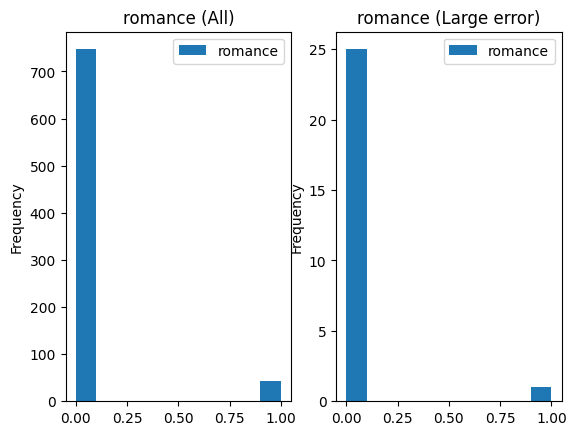

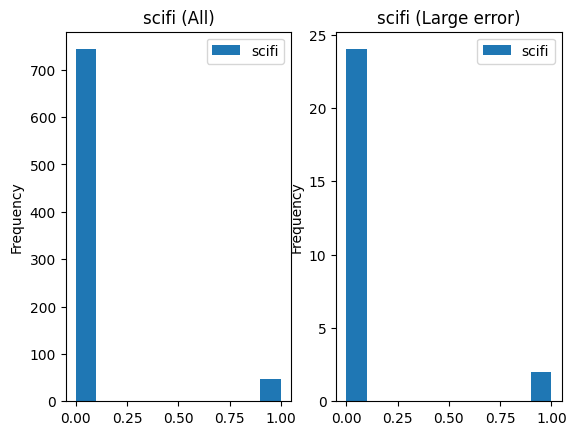

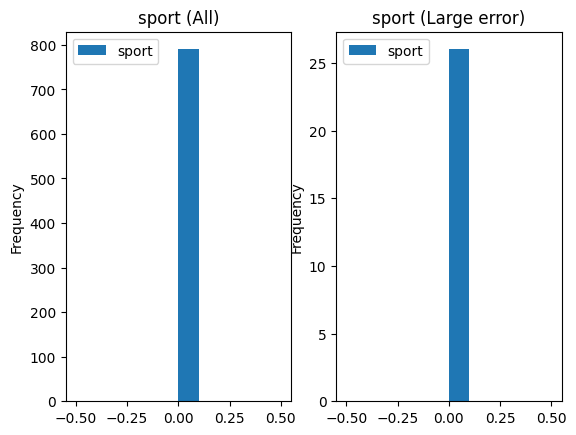

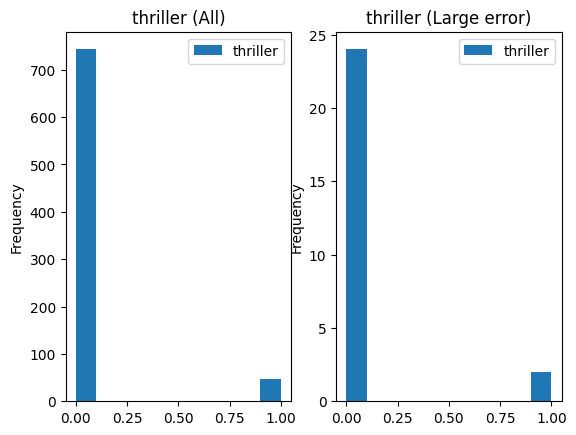

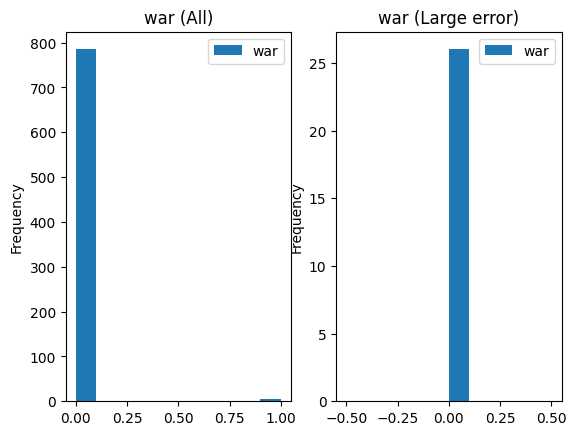

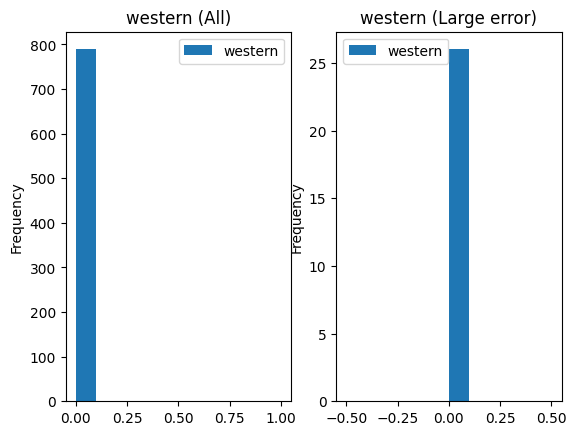

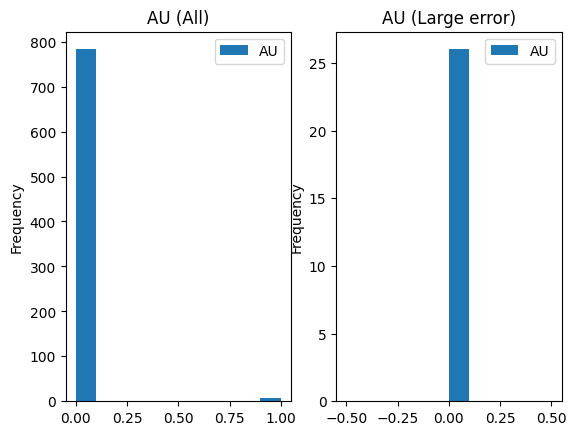

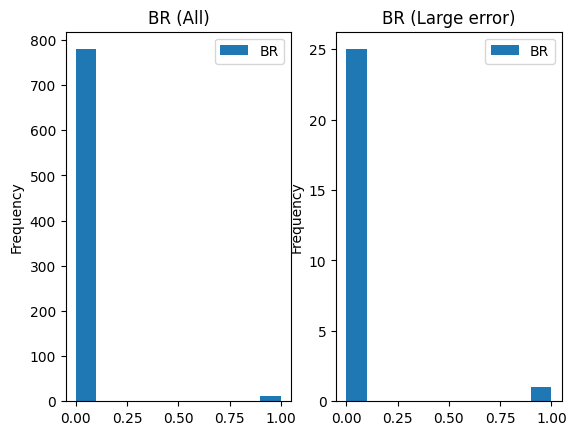

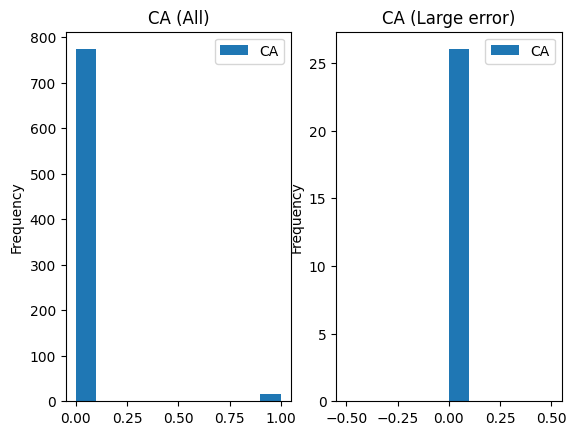

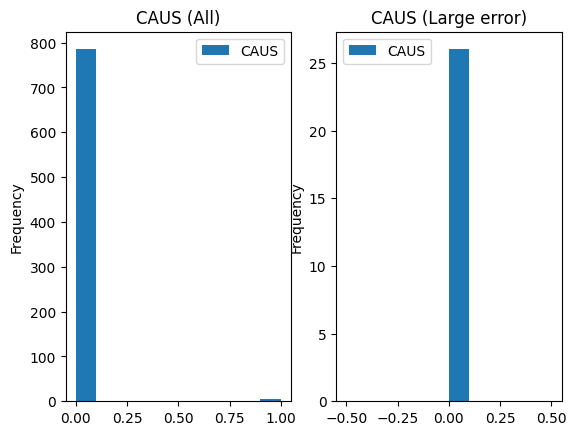

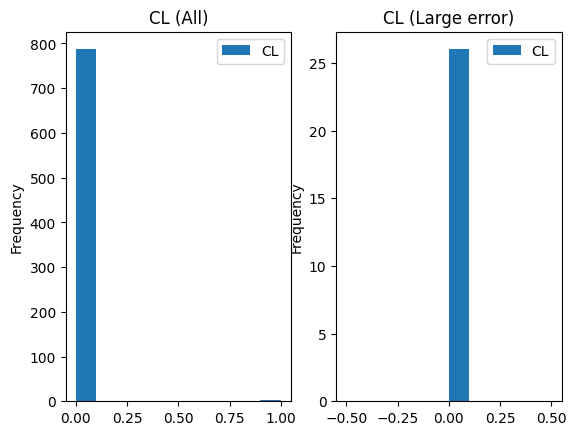

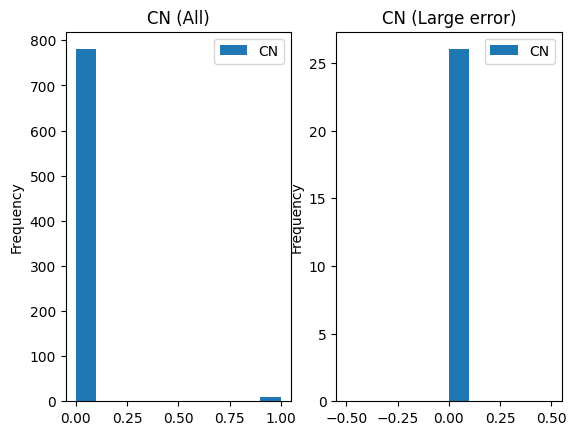

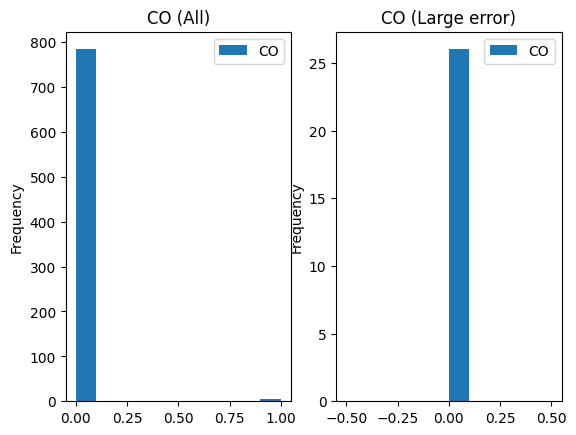

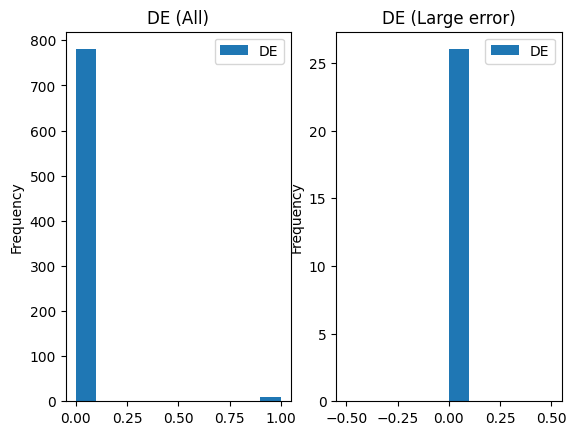

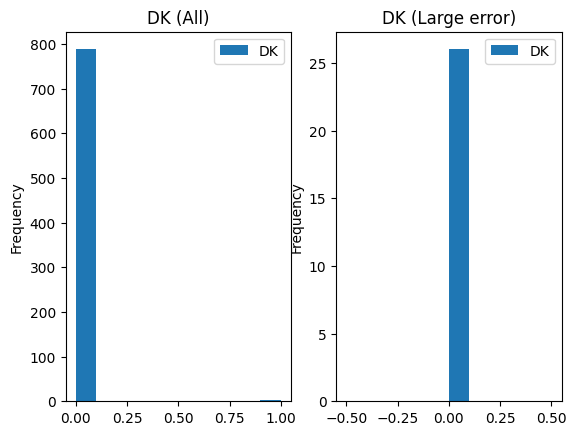

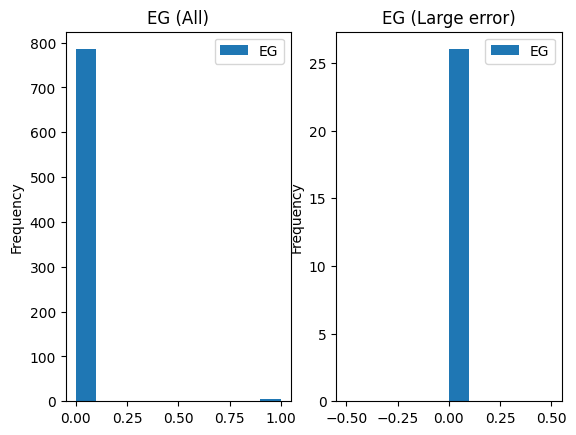

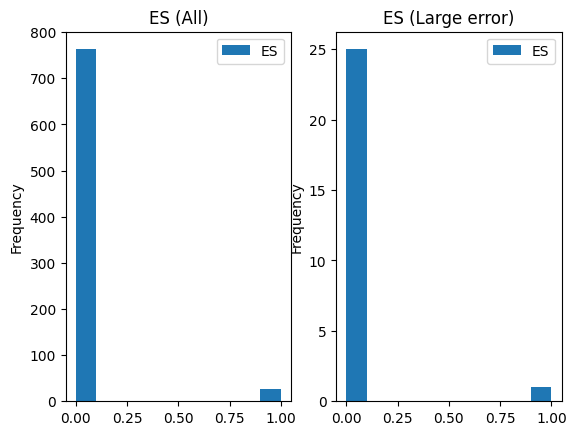

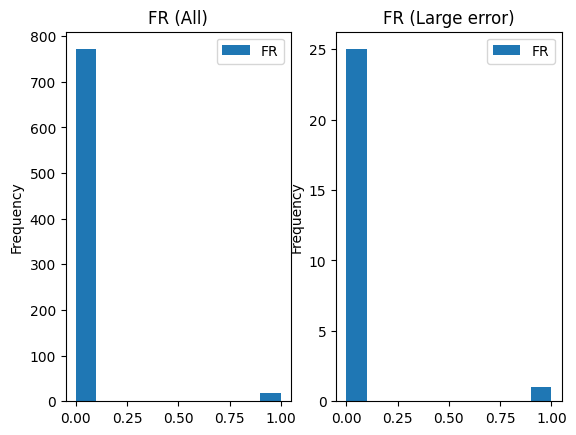

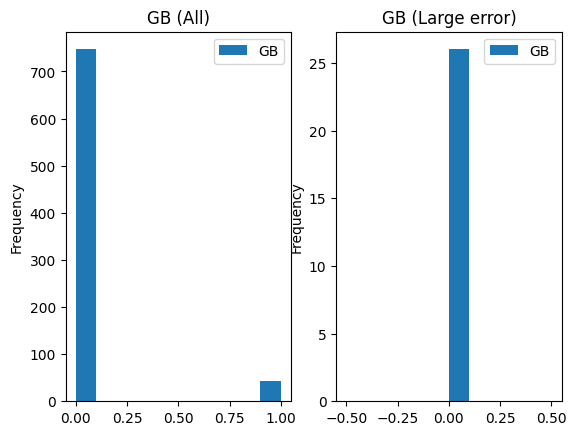

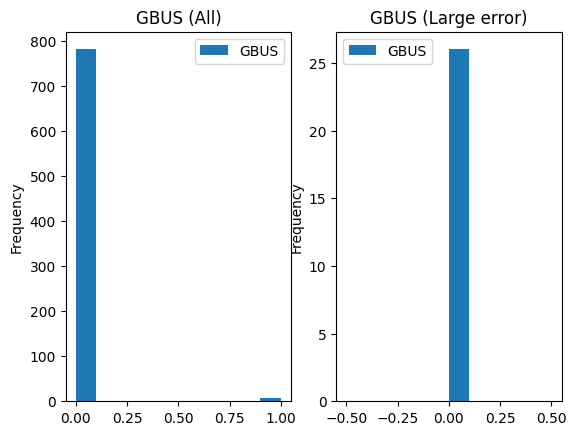

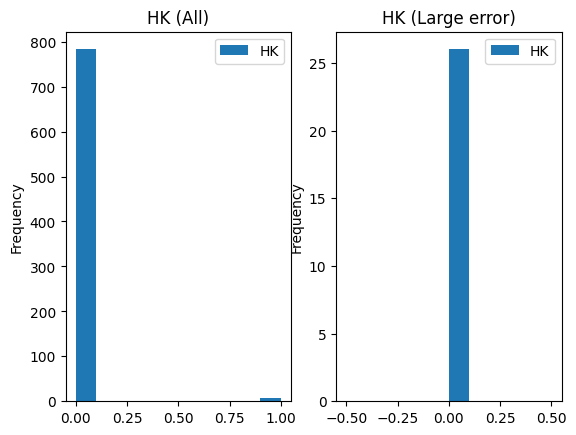

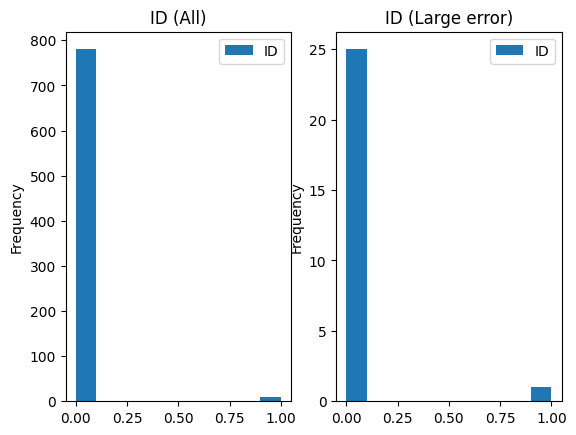

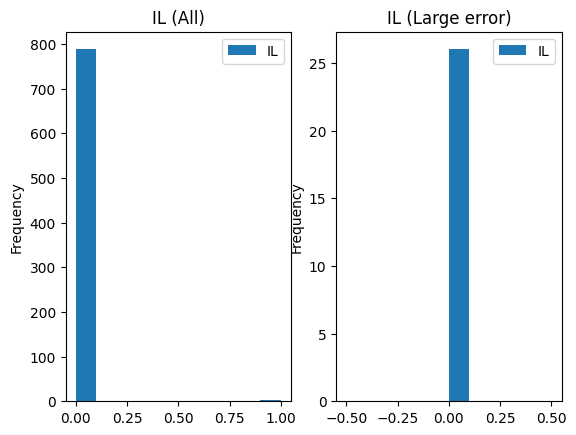

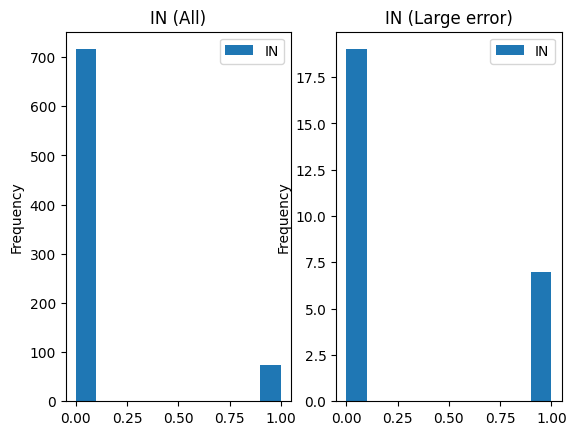

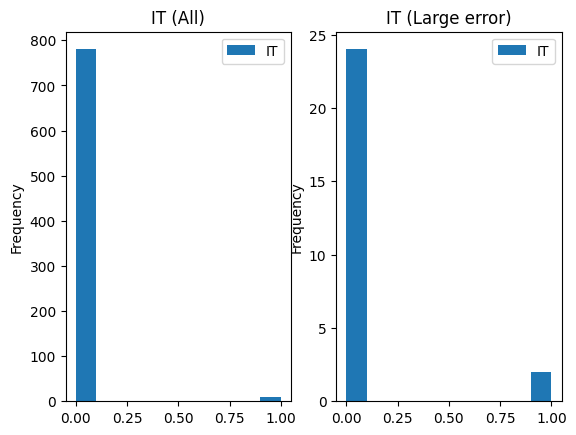

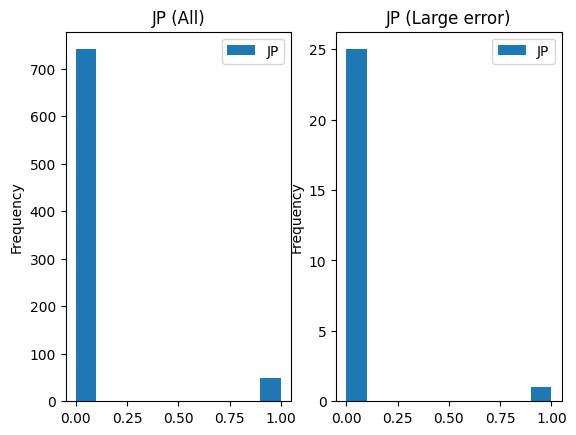

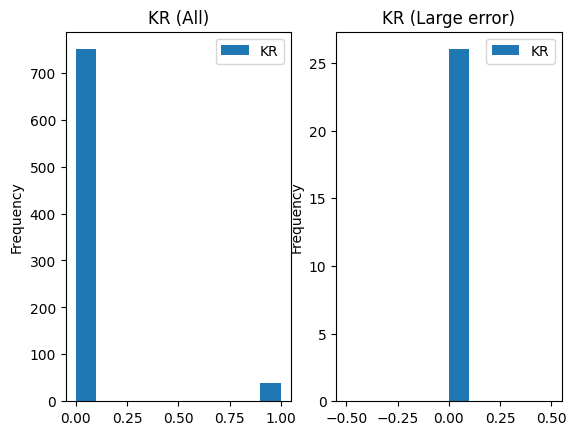

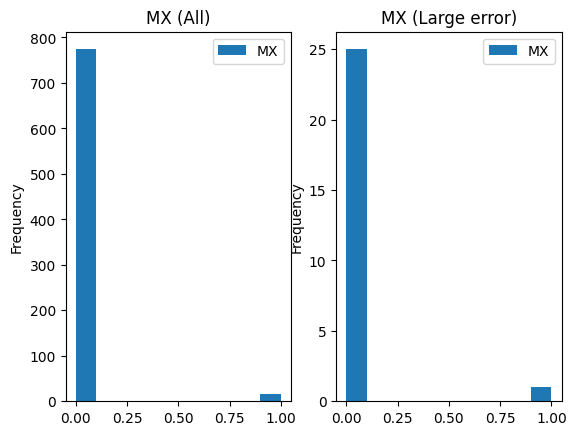

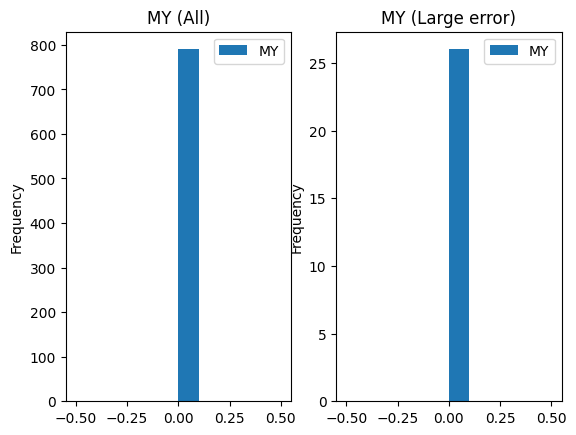

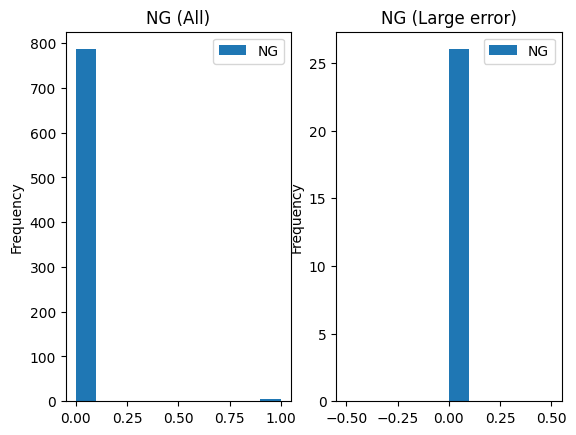

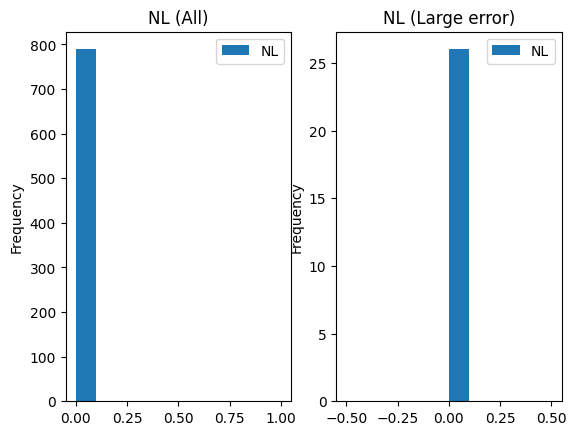

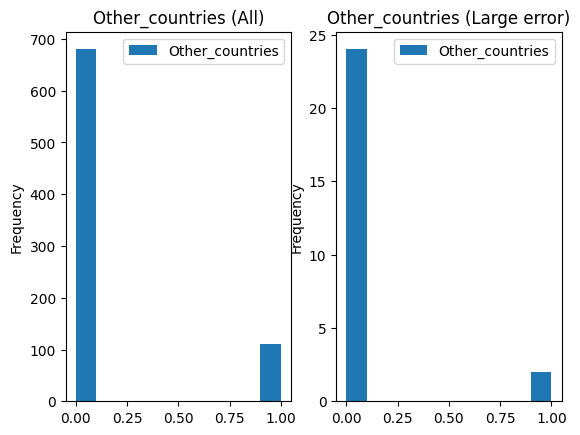

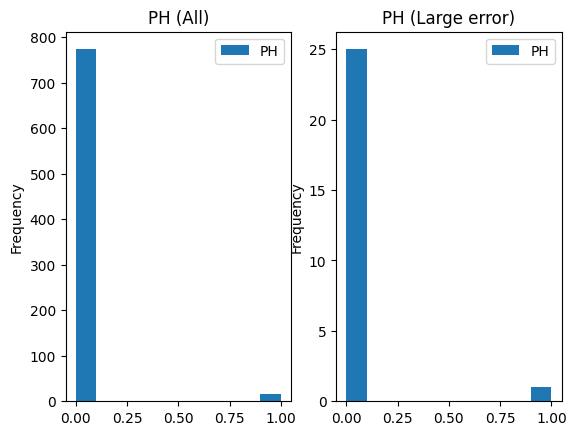

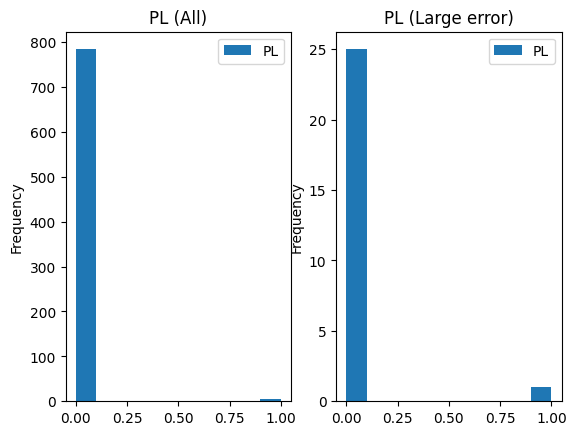

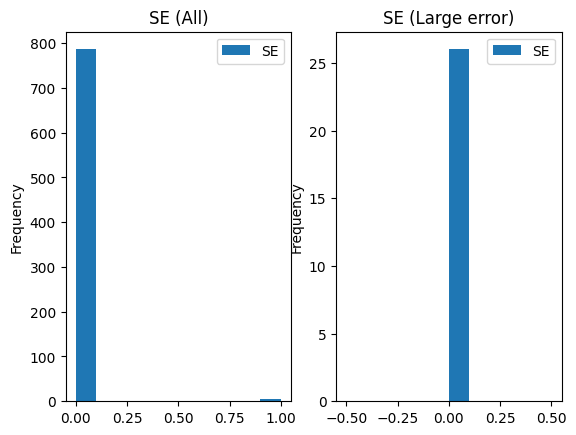

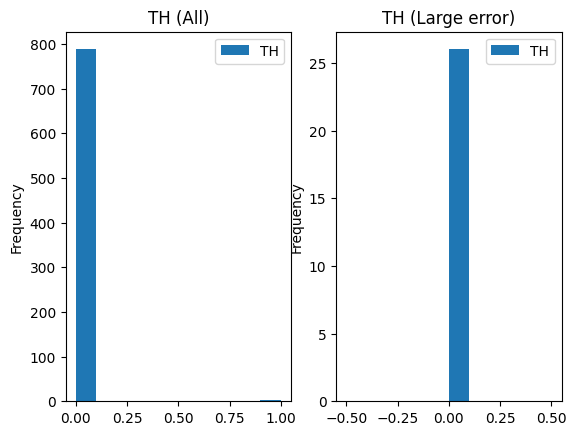

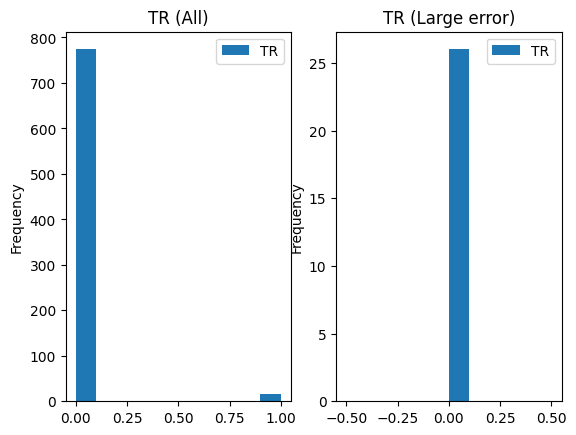

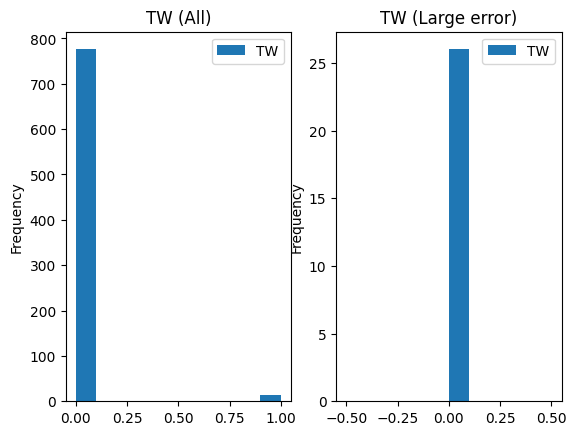

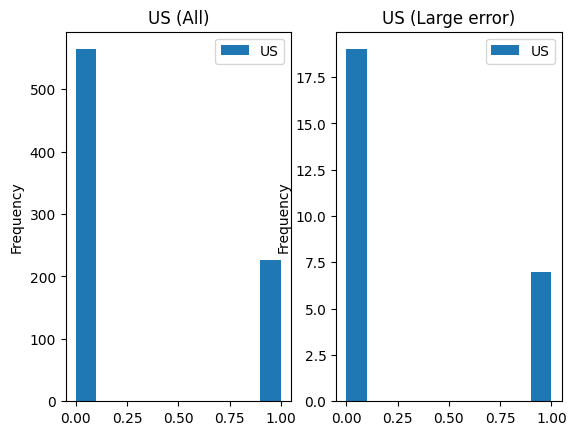

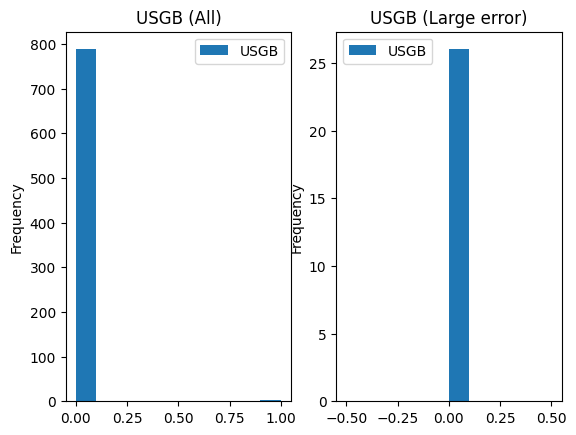

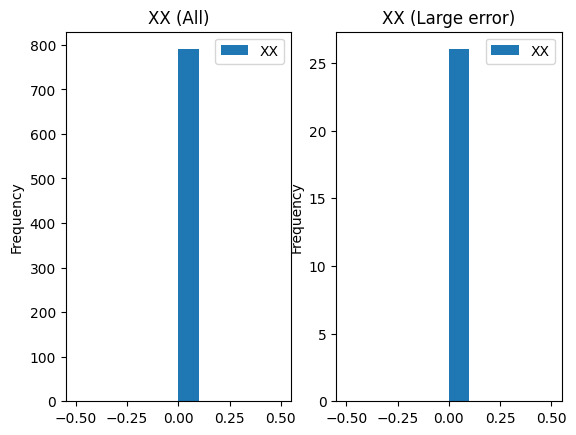

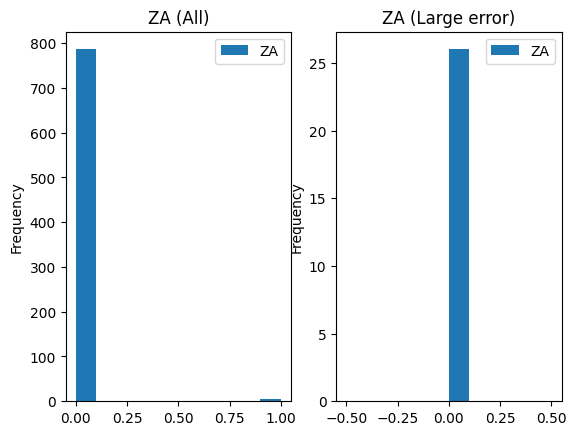

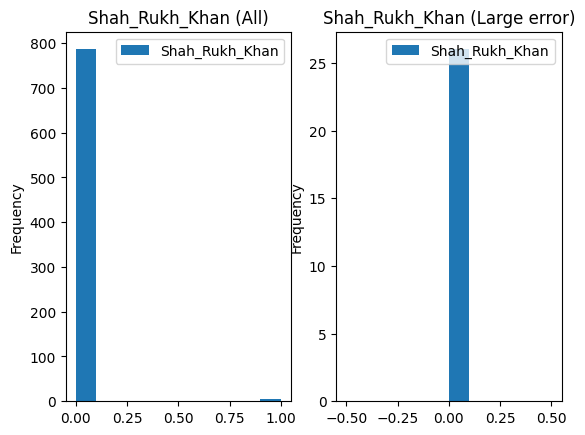

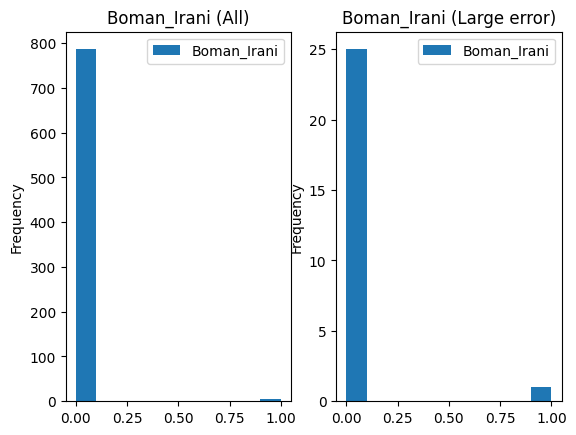

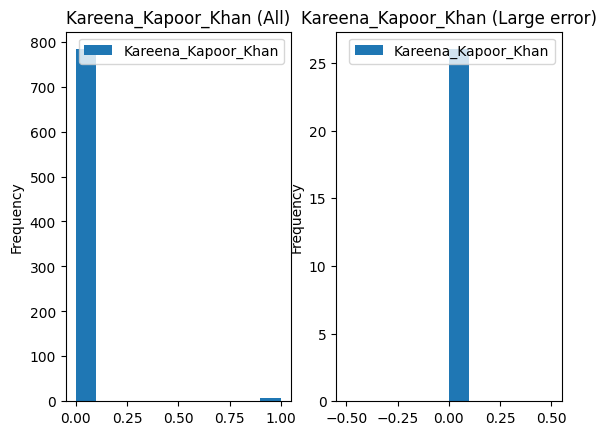

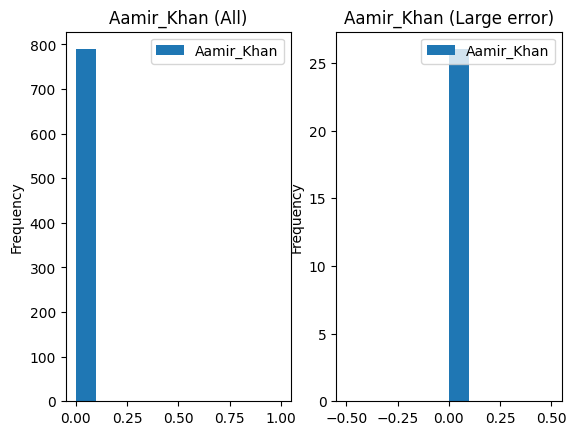

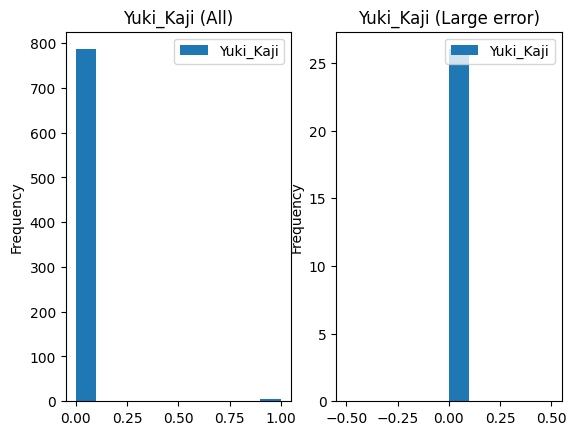

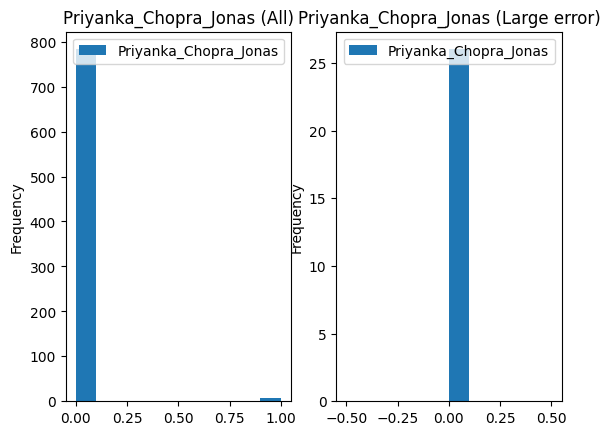

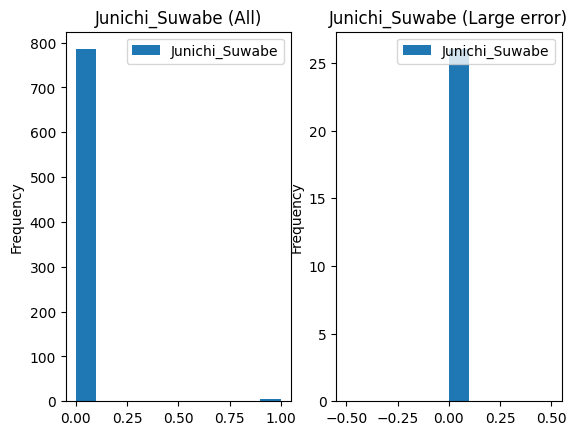

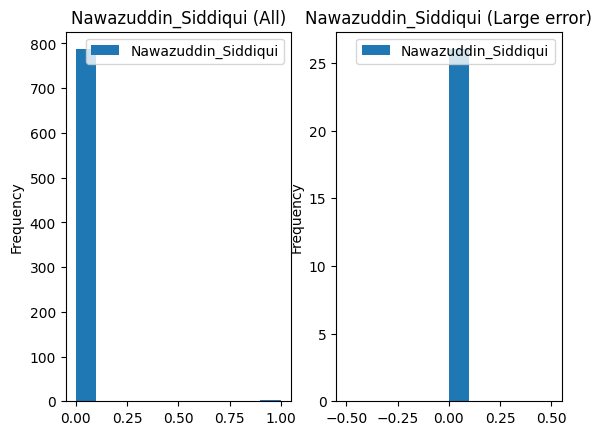

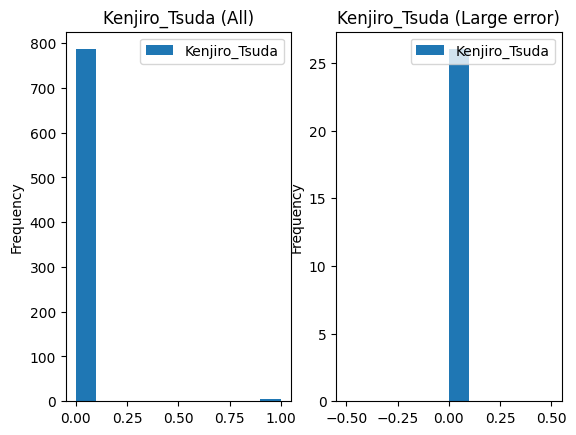

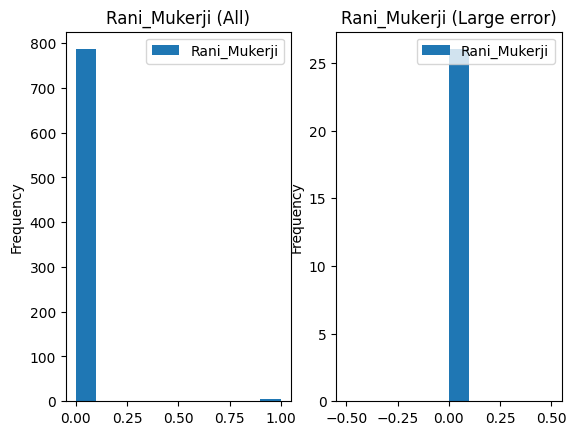

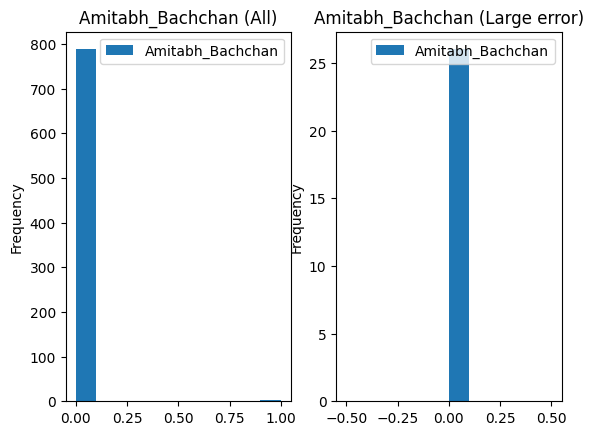

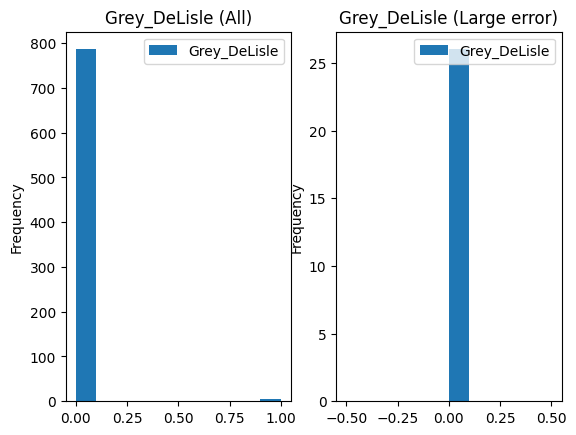

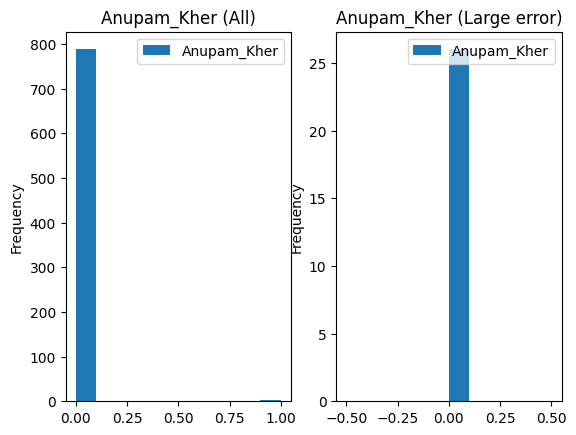

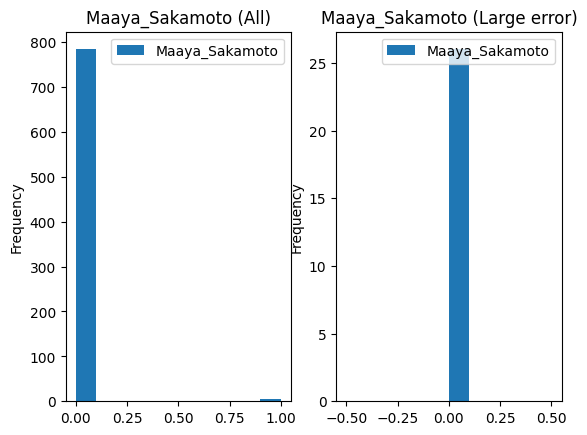

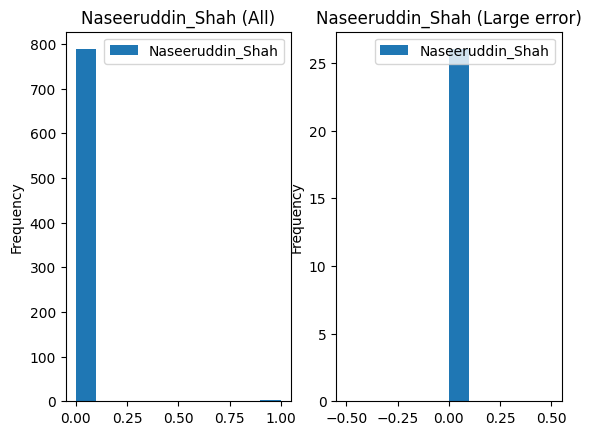

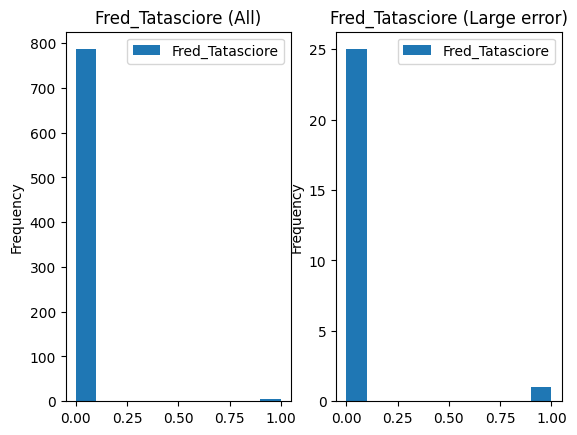

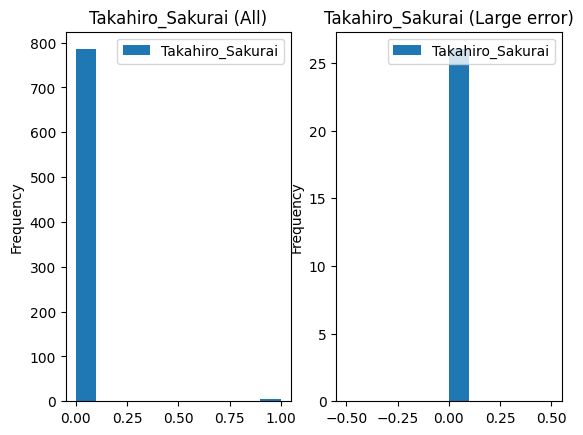

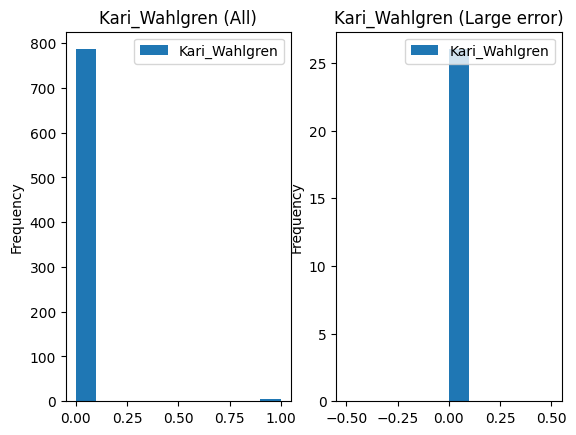

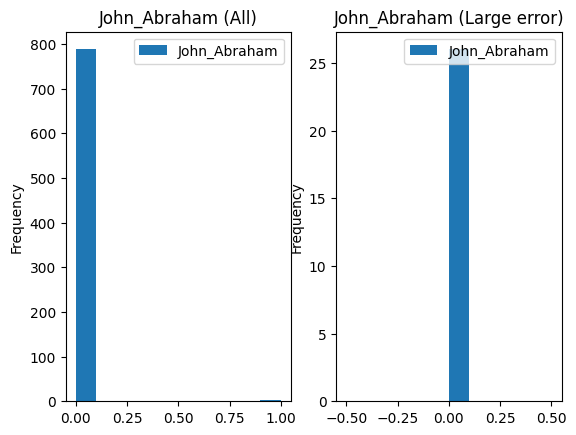

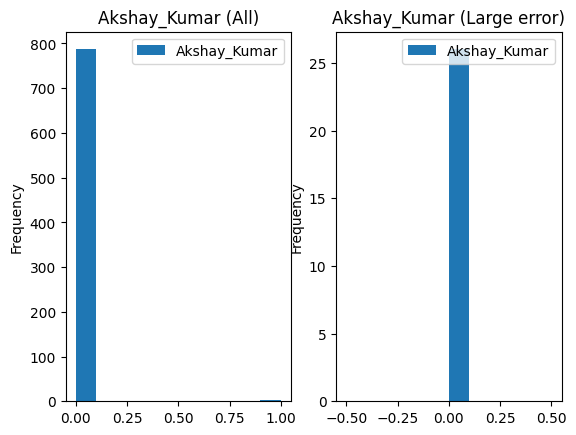

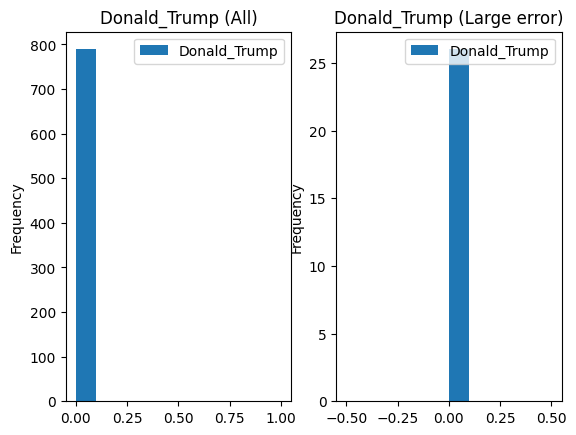

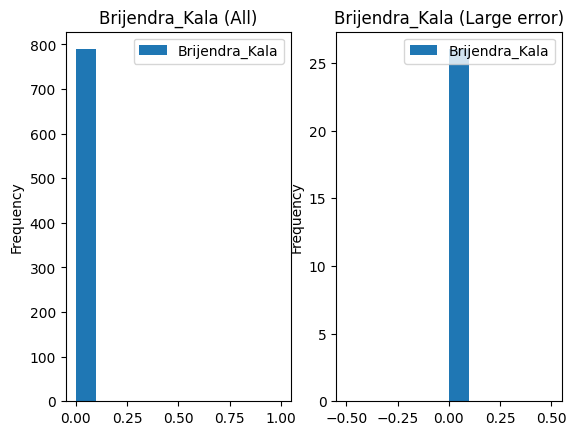

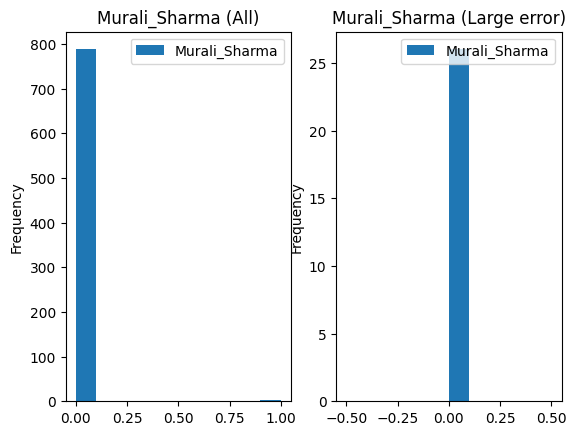

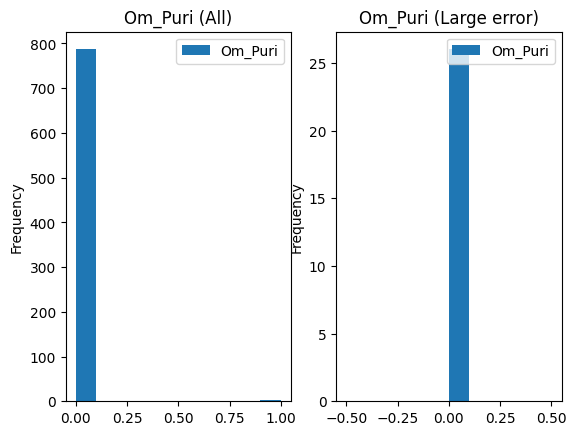

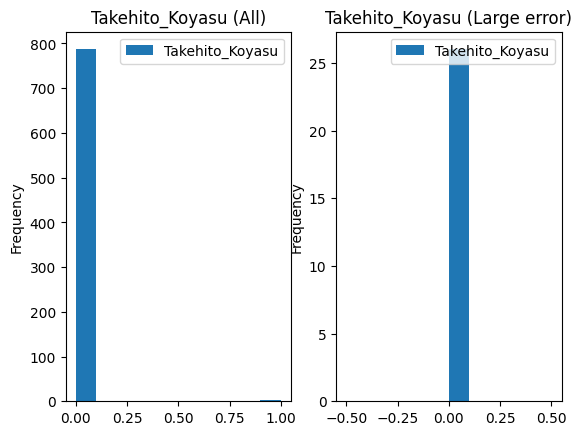

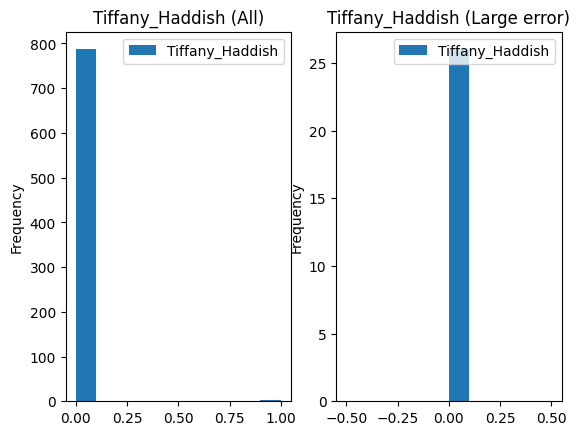

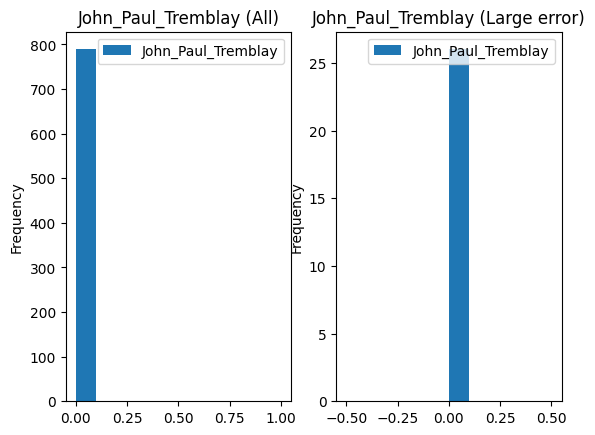

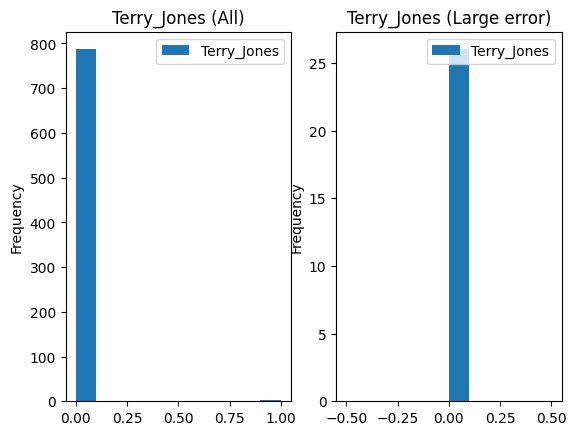

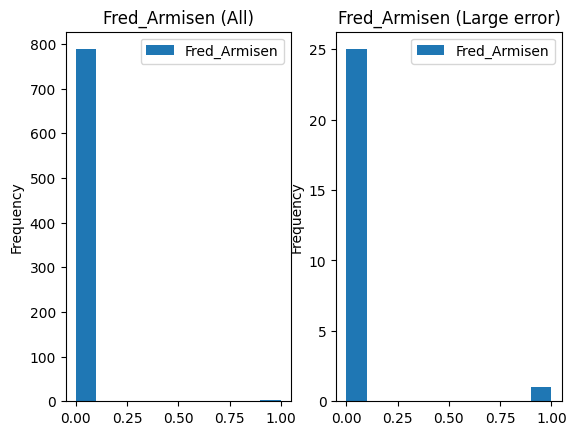

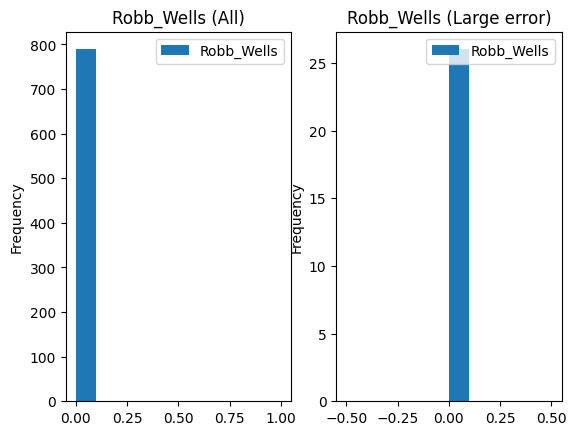

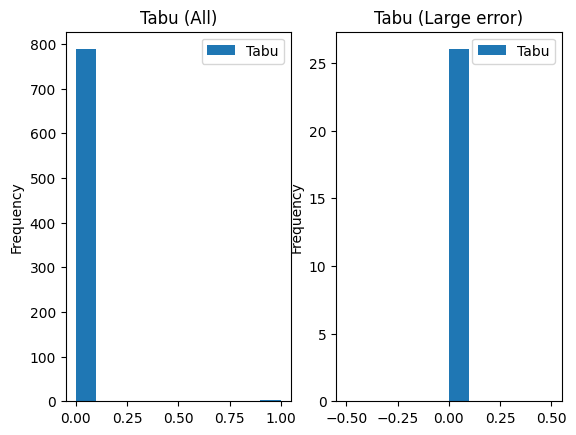

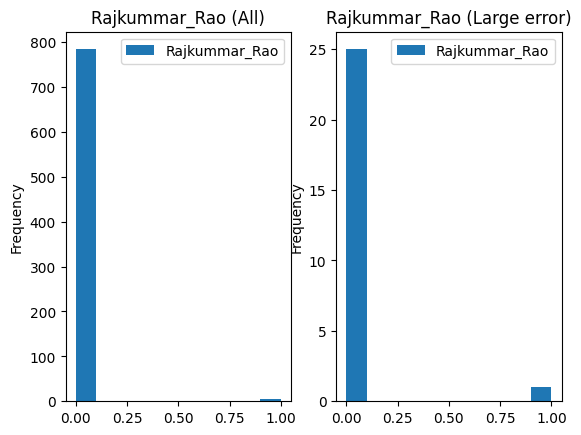

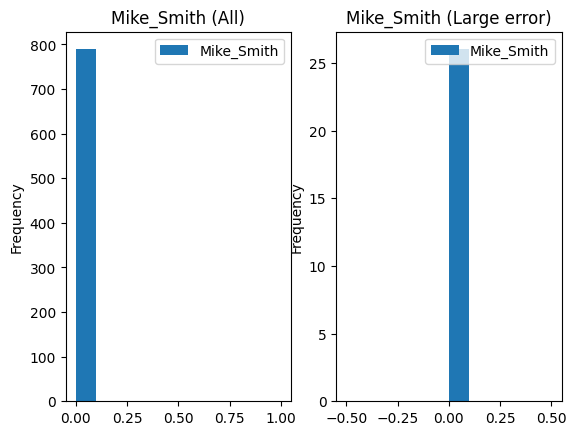

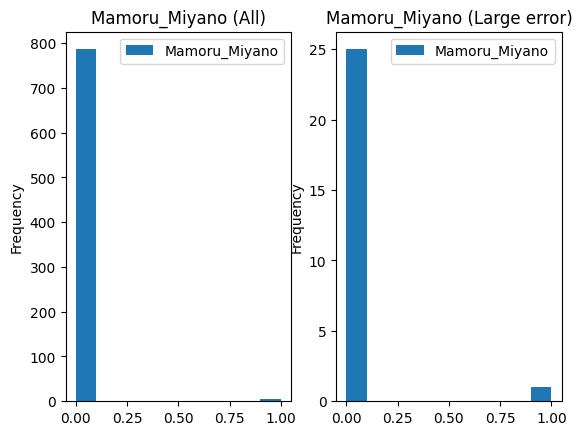

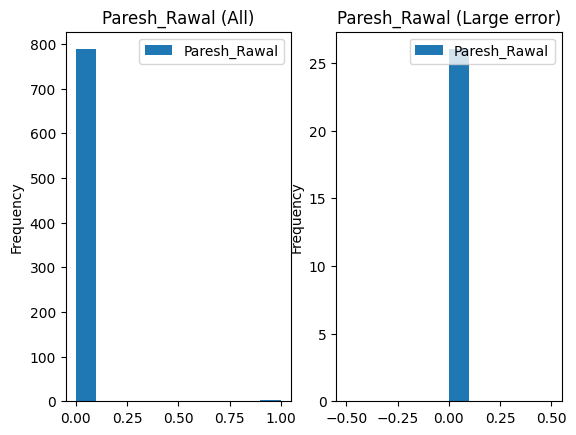

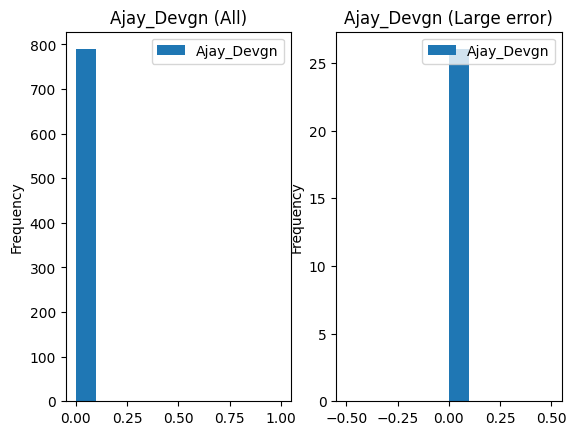

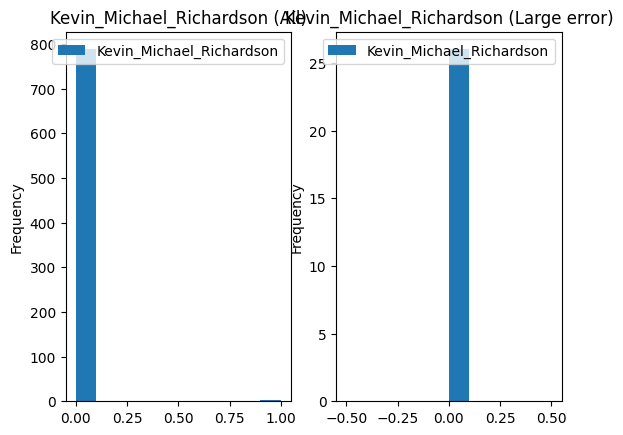

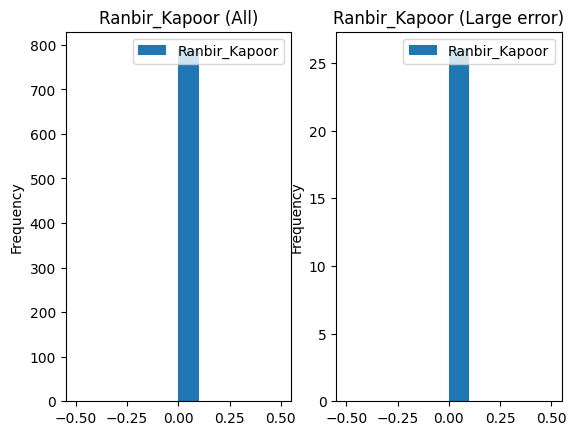

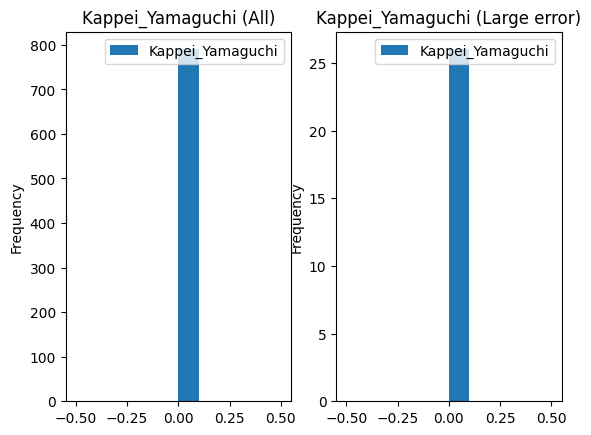

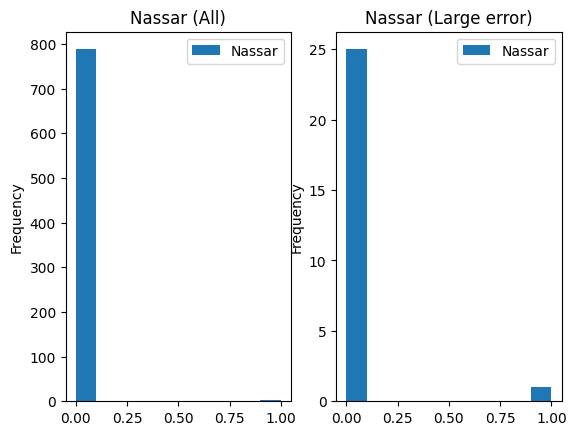

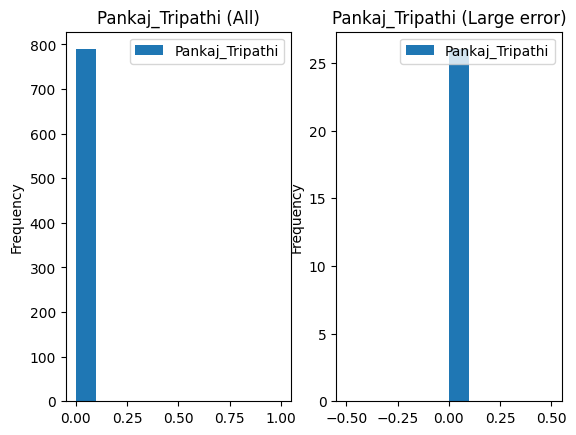

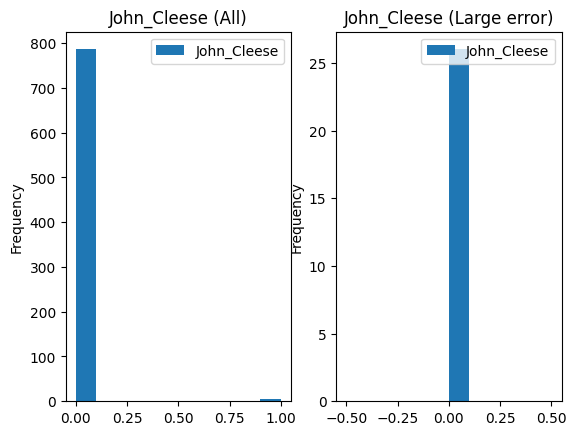

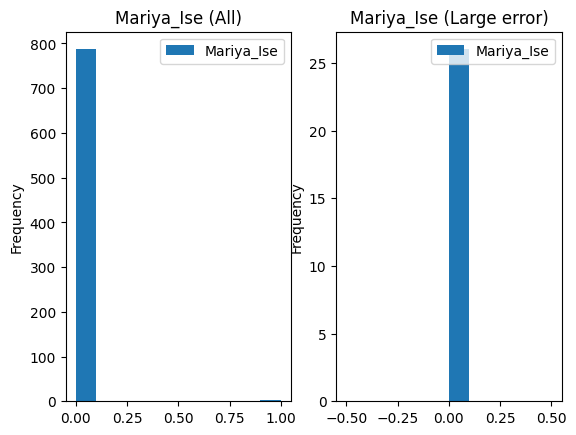

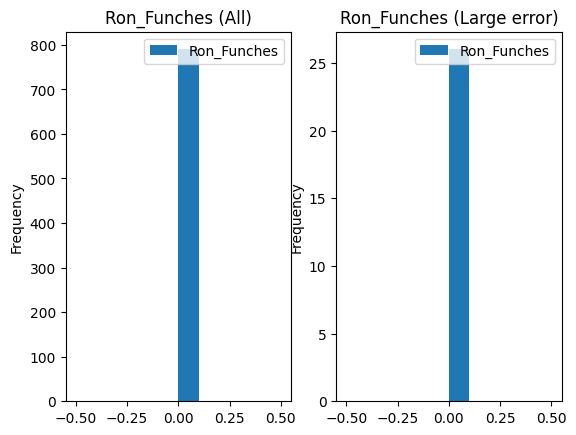

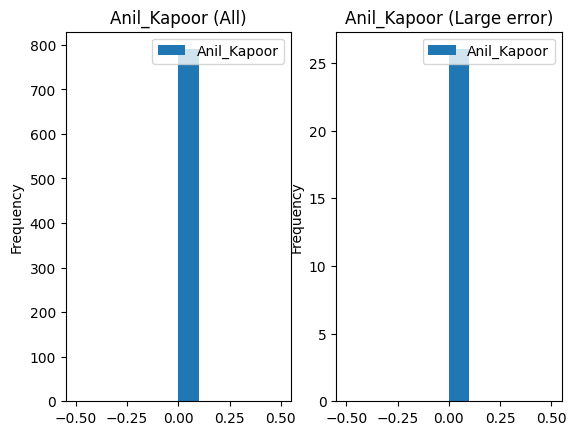

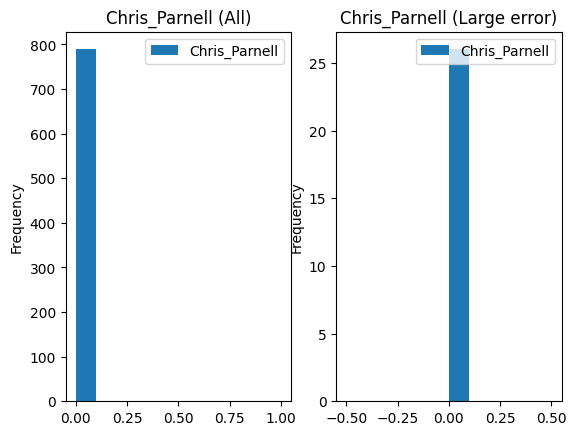

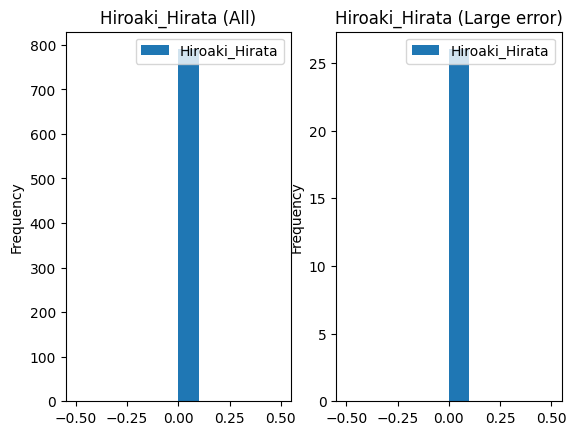

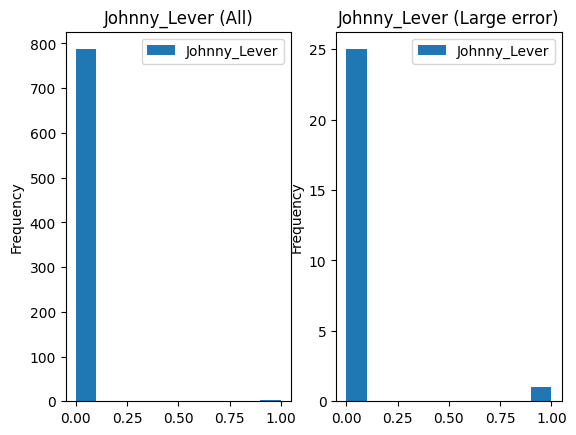

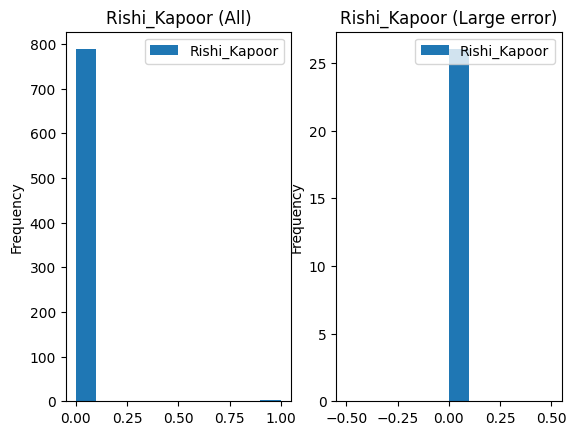

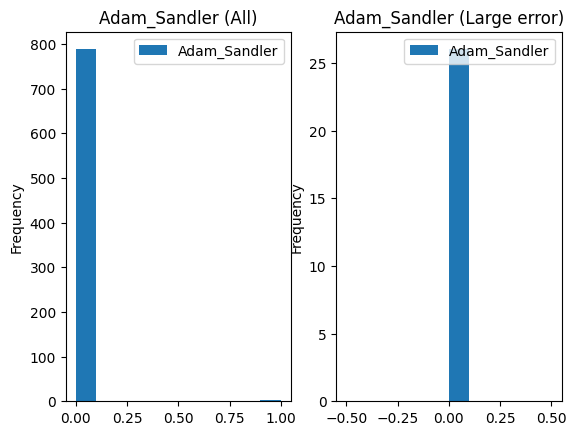

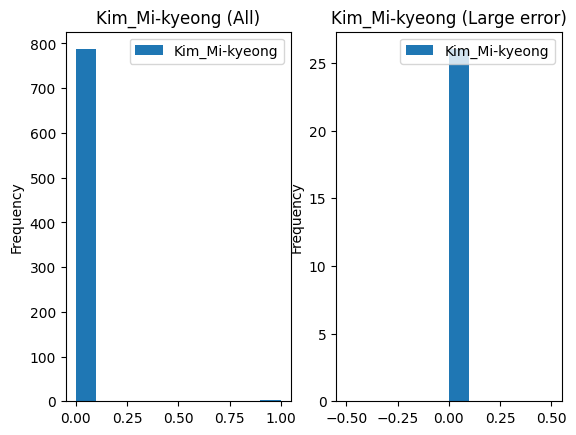

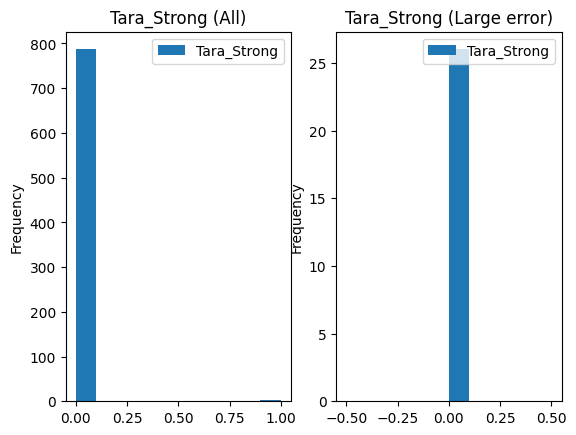

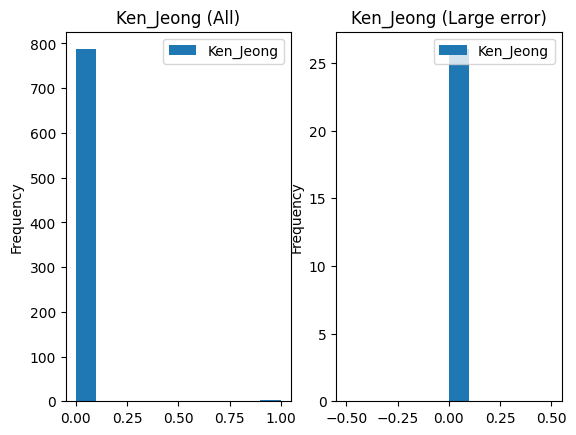

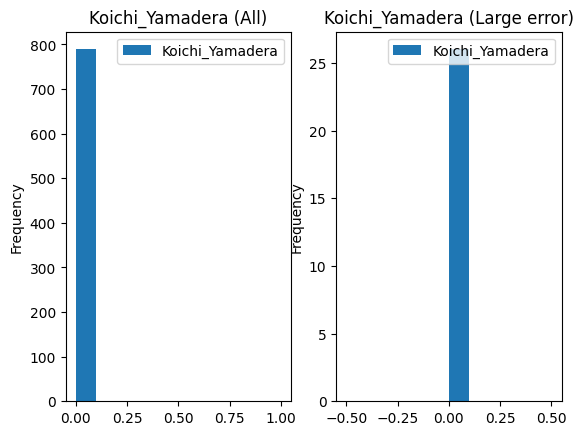

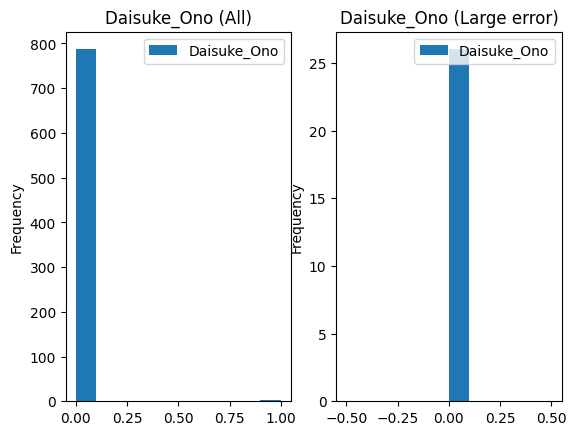

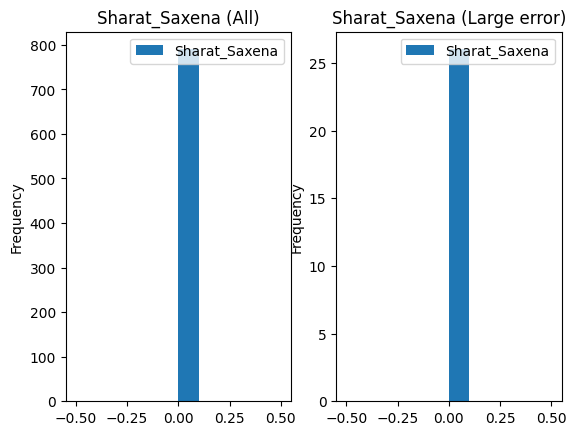

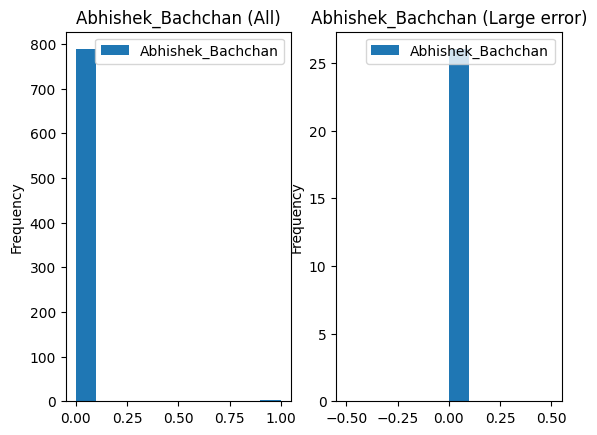

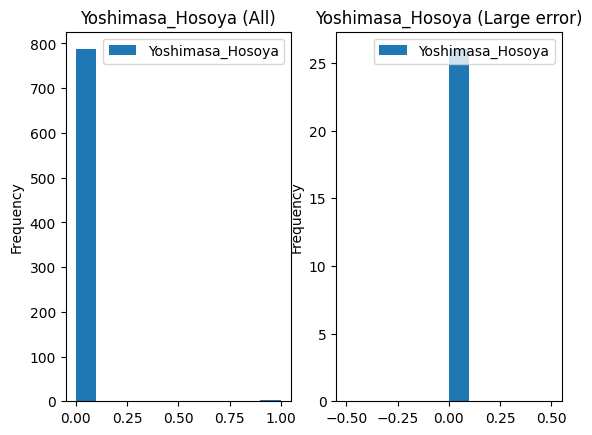

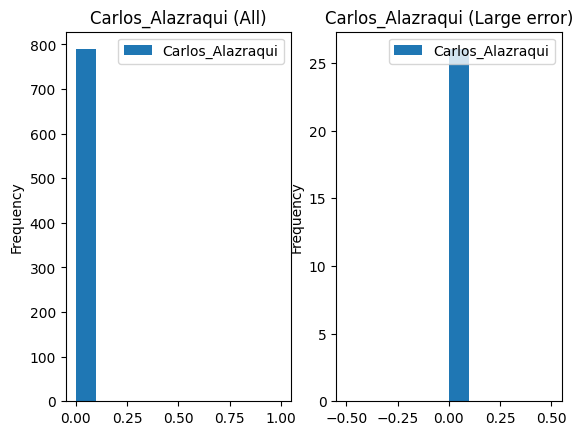

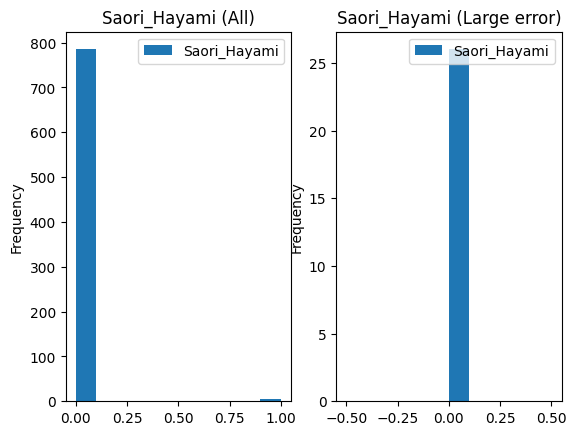

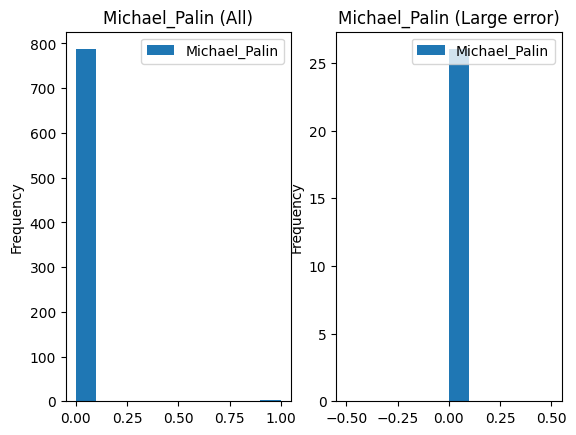

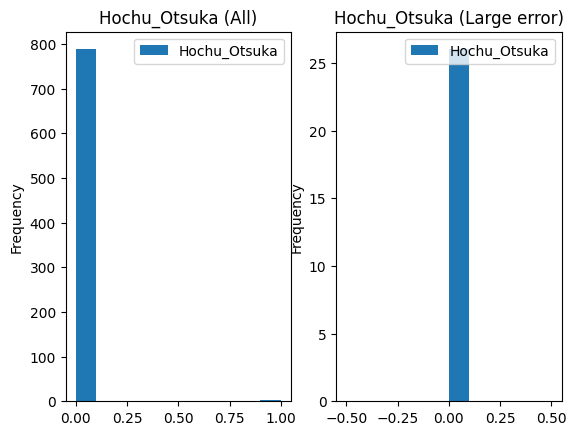

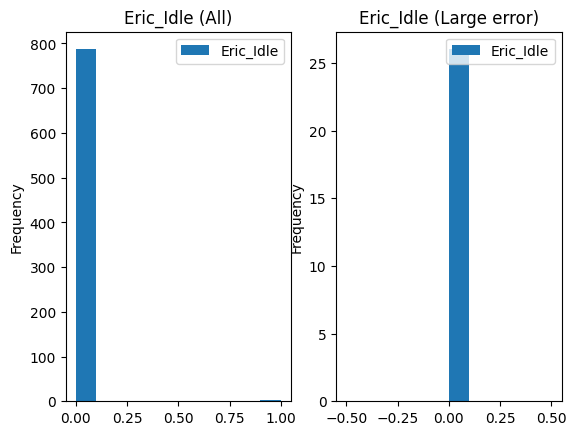

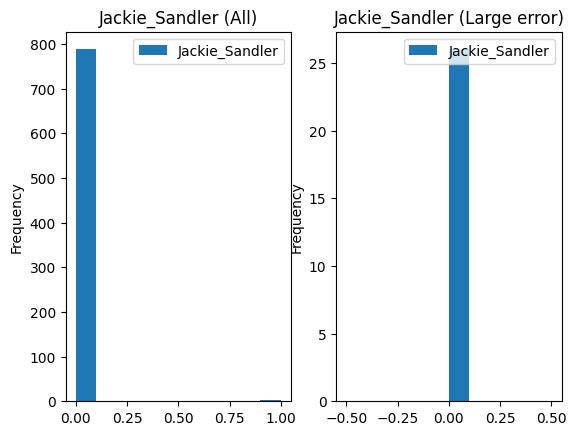

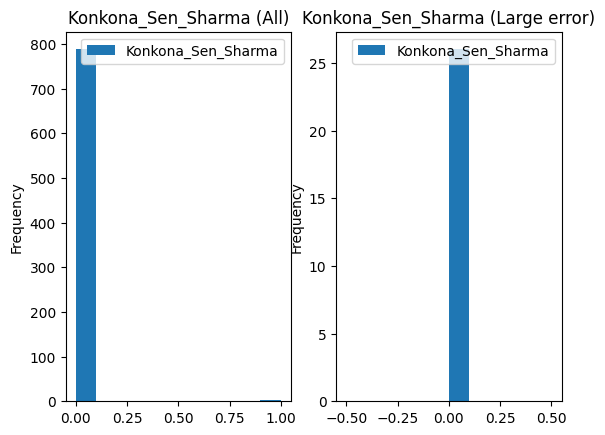

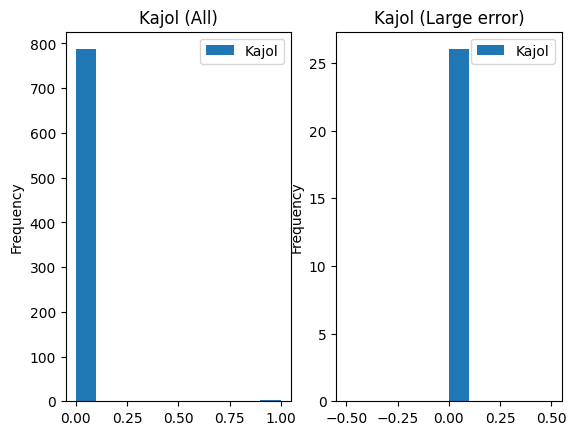

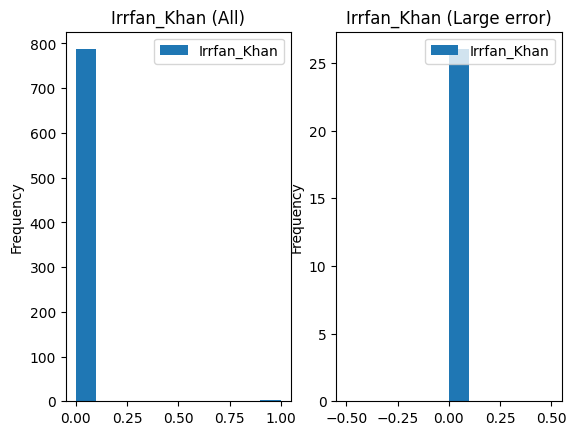

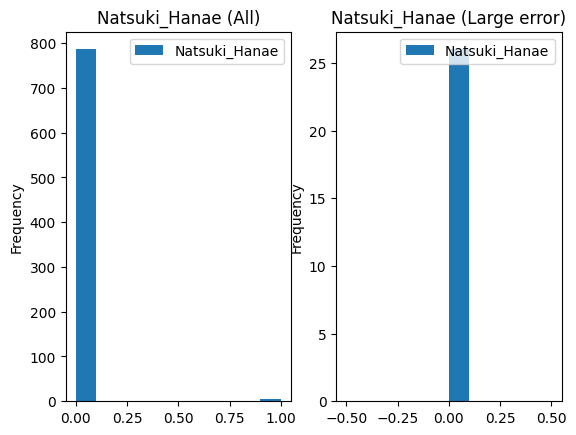

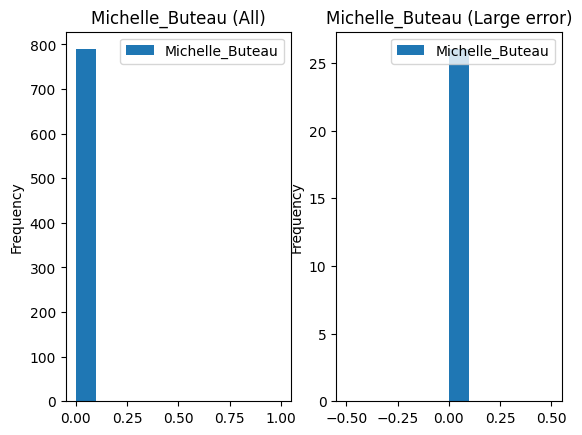

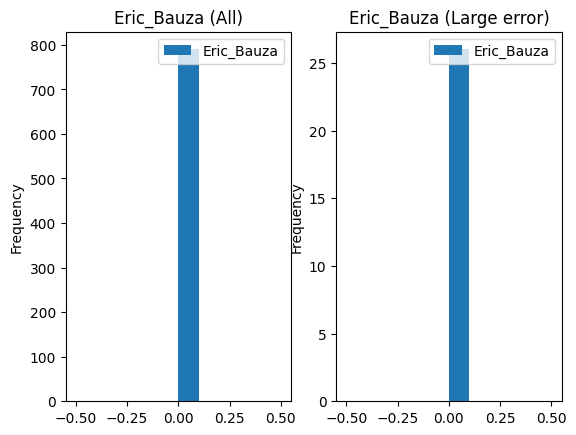

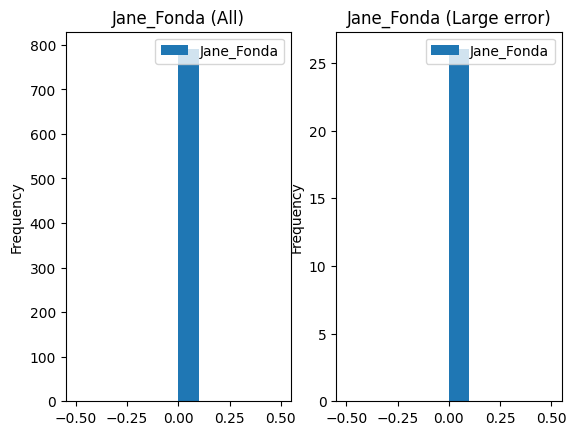

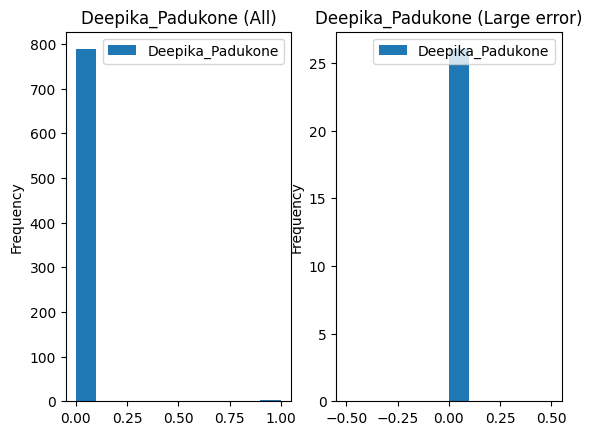

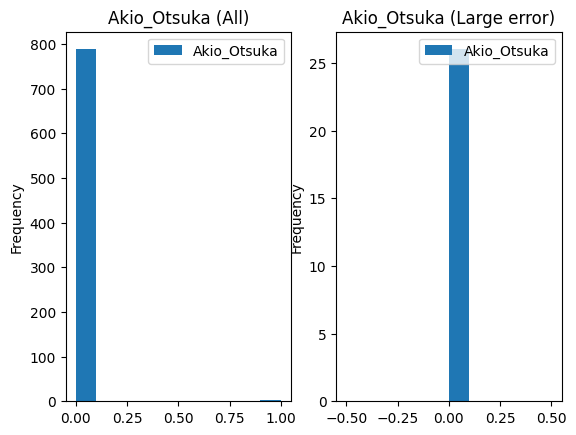

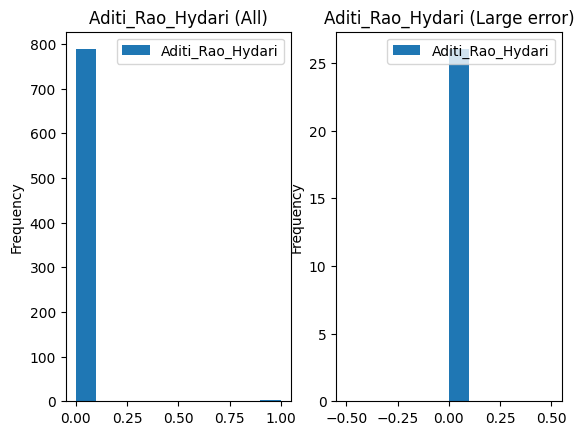

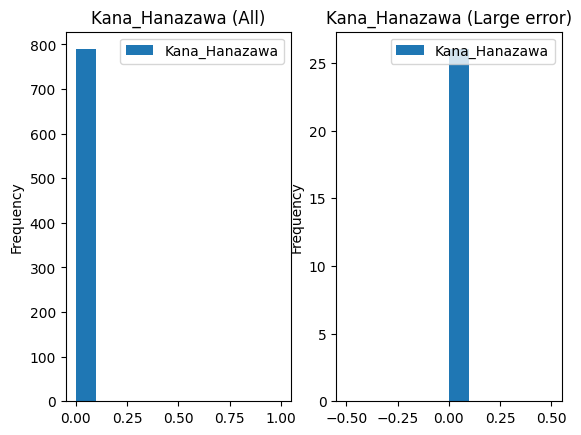

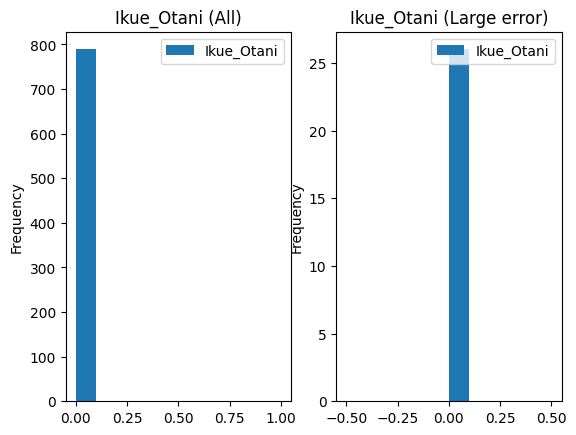

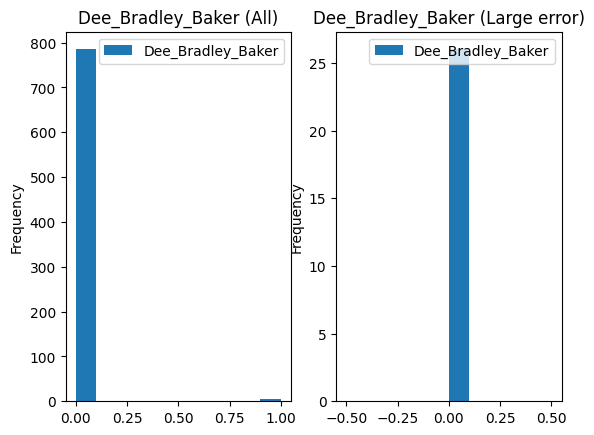

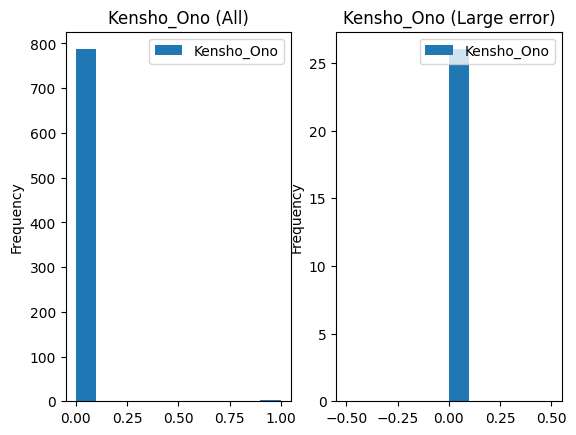

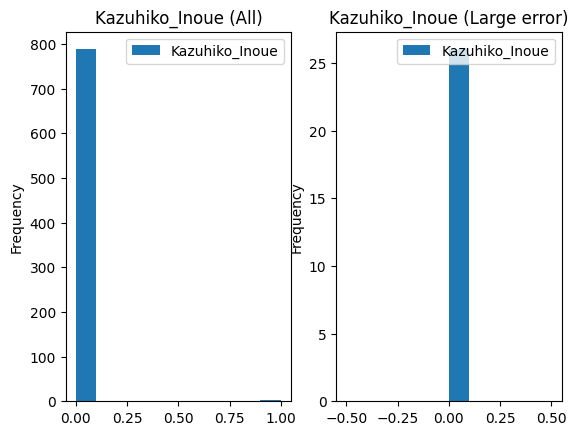

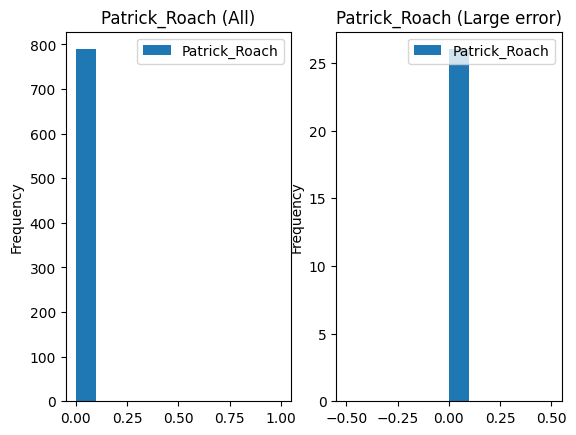

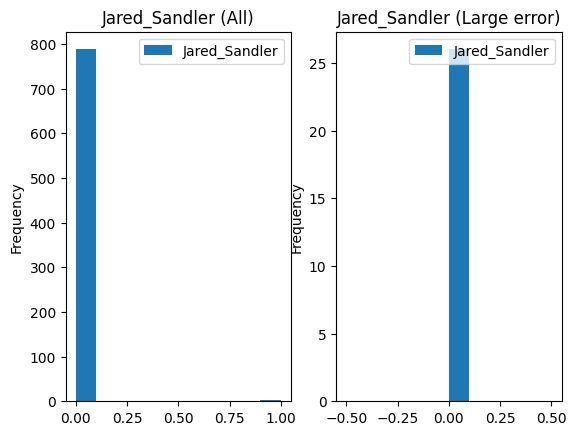

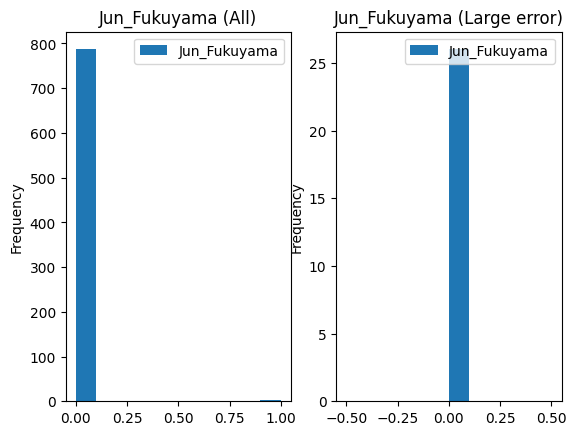

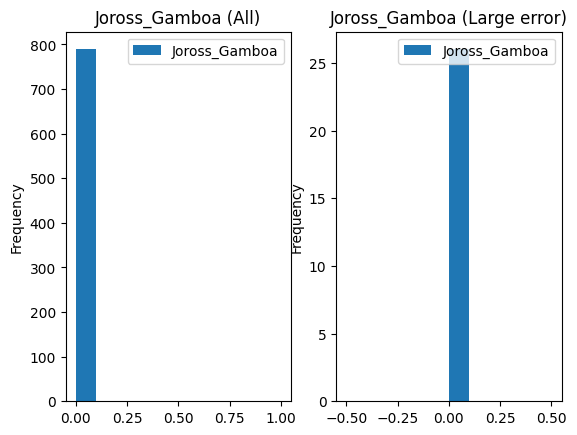

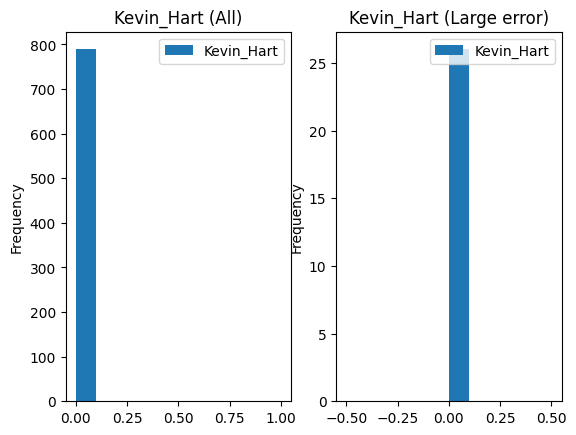

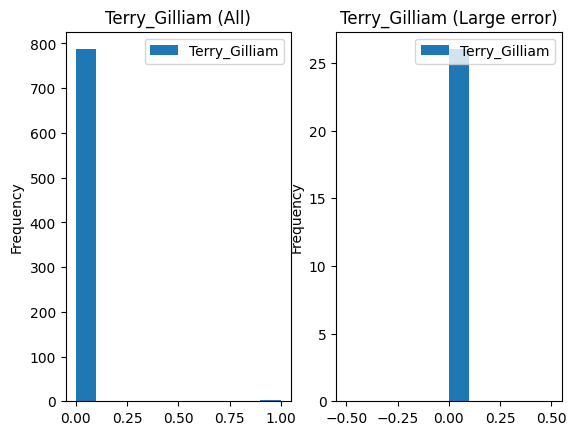

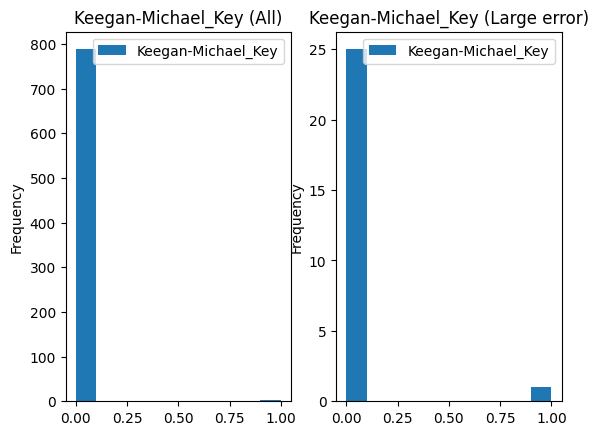

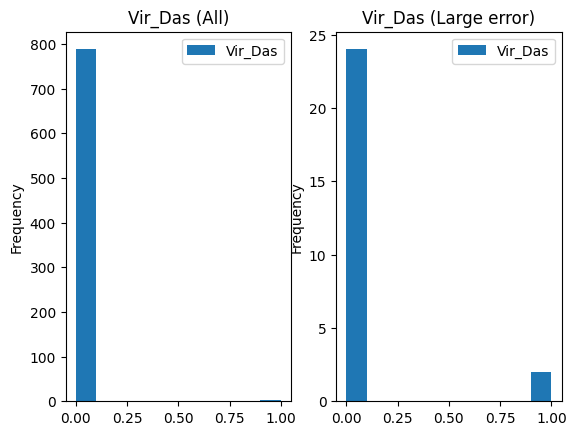

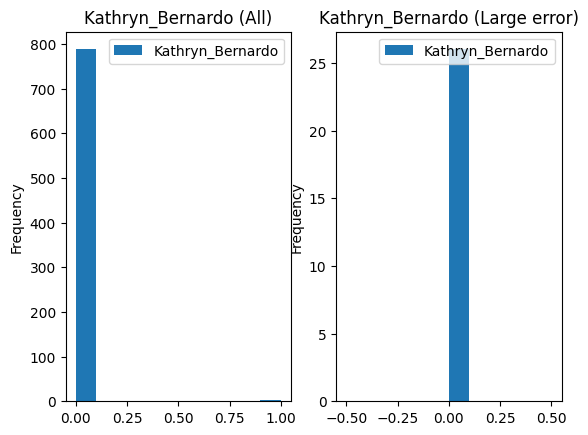

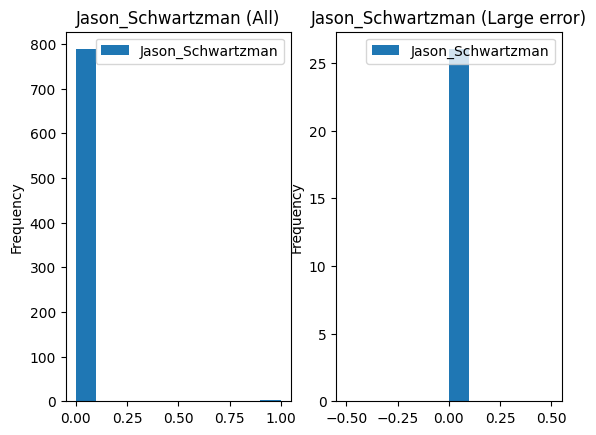

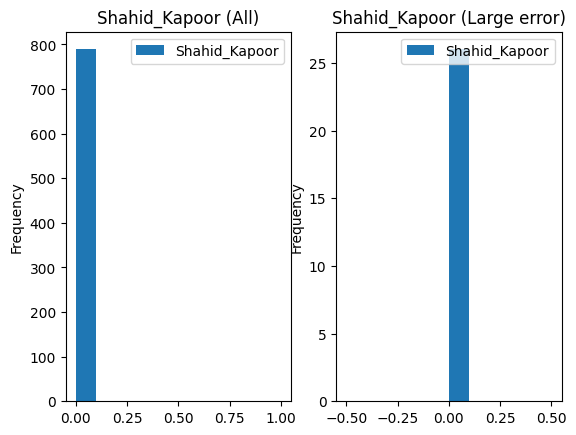

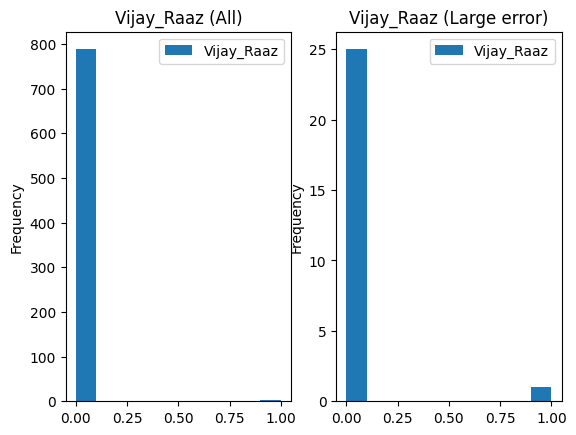

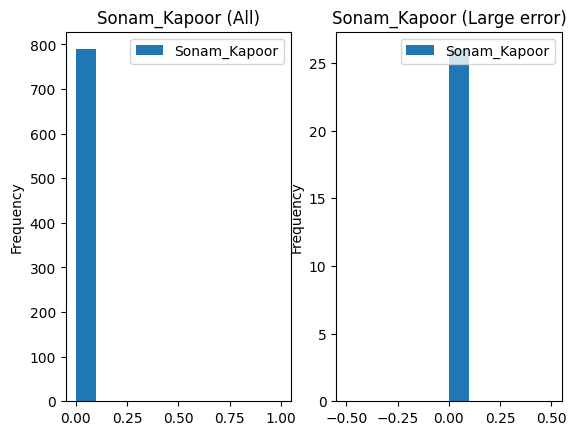

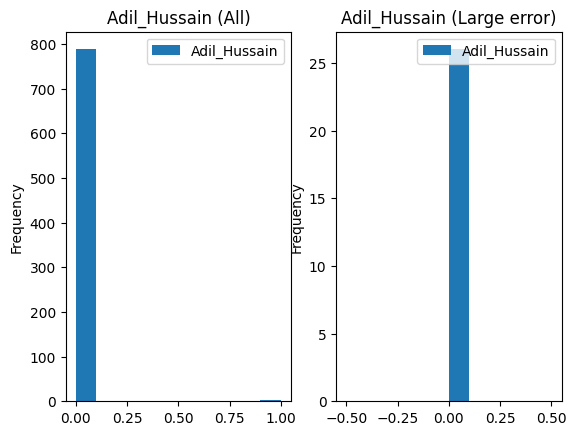

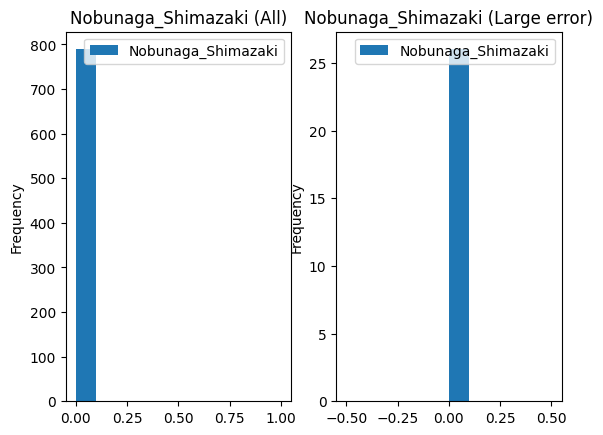

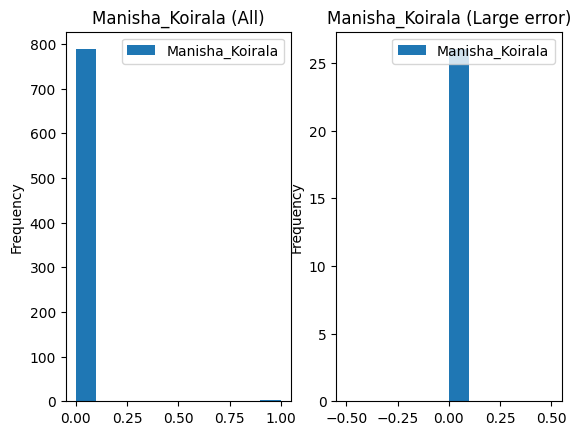

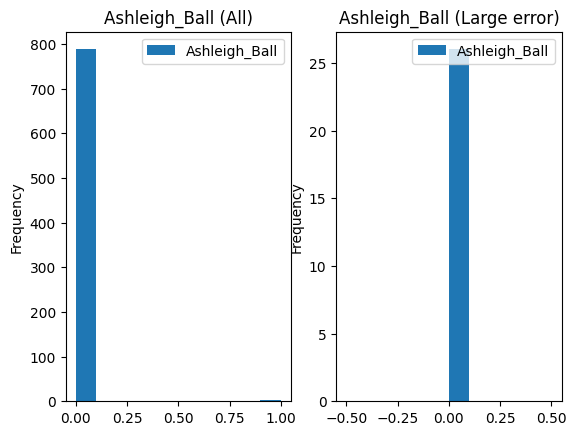

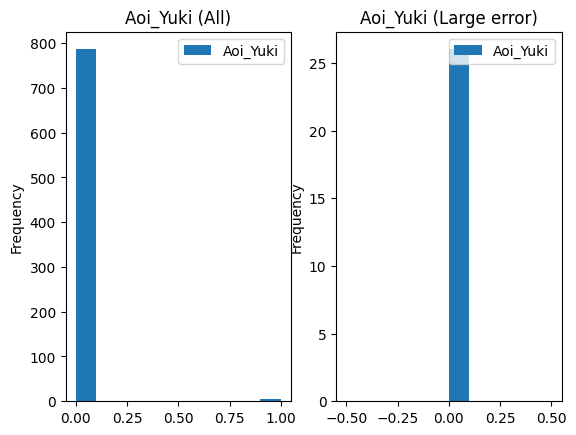

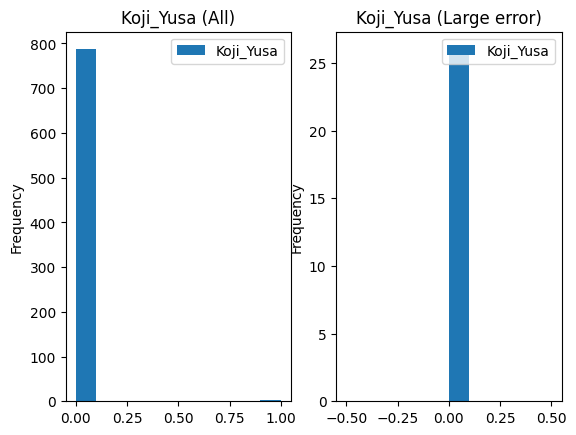

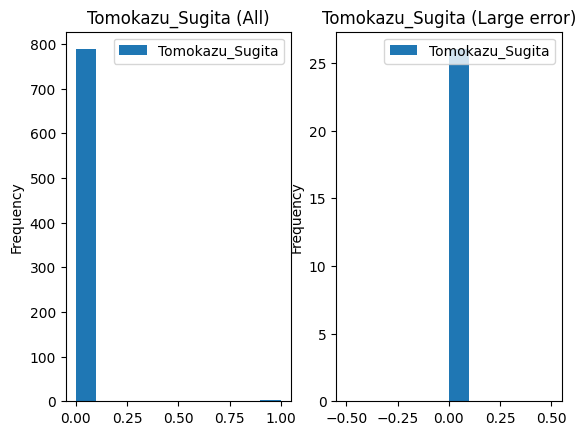

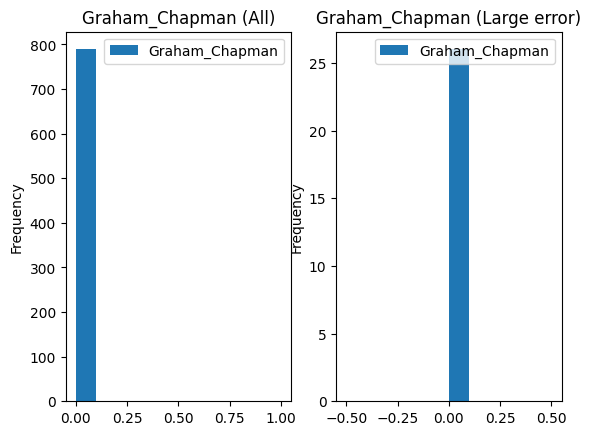

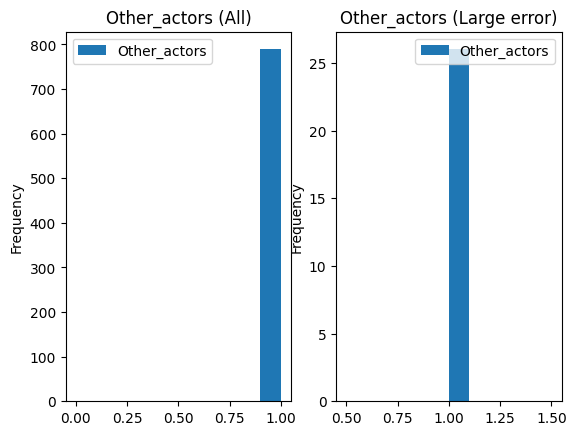

In [23]:
import matplotlib.pyplot as plt
for column in X_test.columns:
  fig, (ax1, ax2) = plt.subplots(1, 2) # required if we want to plot multiple figures from the same cell
  df_with_predictions.plot(kind='hist', y=column, title=f'{column} (All)', ax=ax1)
  df_with_predictions[df_with_predictions.pred_diff > 2].plot(kind='hist', y=column, title=f'{column} (Large error)', ax=ax2)

- man sieht, dass das Modell Probleme bei der Vorhersage der runtime hat
- Filme mit imdb_votes unter 50.000 werden auch schlecht vorhergesagt

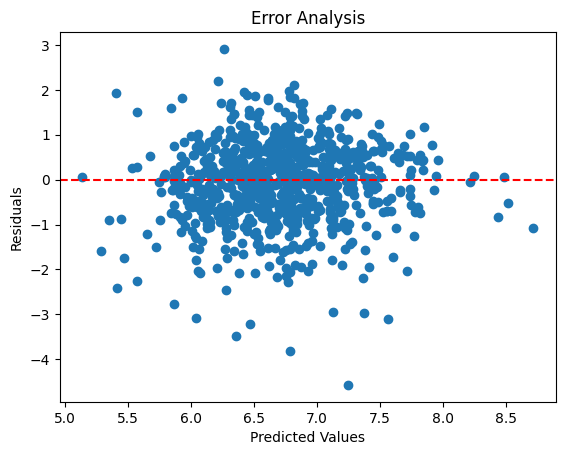

           Actual   Predicted   Residuals
count  790.000000  790.000000  790.000000
mean     6.638781    6.721708   -0.082927
std      1.062946    0.513889    0.907912
min      2.675000    5.138918   -4.569735
25%      5.950000    6.368986   -0.623900
50%      6.725000    6.732924   -0.013877
75%      7.375000    7.063156    0.529127
max      9.175000    8.716640    2.909903


In [24]:
y_pred = optimized_svm.predict(X_test)

# Fehleranalyse
residuals = y_test - y_pred
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residuals': residuals})

# Plotten der Fehleranalyse
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Error Analysis')
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei Residuals=0
plt.show()

# Statistiken der Fehleranalyse
error_stats = error_df.describe()
print(error_stats)
#Die Fehleranalyse wird grafisch dargestellt, indem die vorhergesagten Werte auf der x-Achse und die Residuen auf der y-Achse geplottet werden.
#Eine horizontale Linie bei Residuen=0 wird ebenfalls hinzugefügt, um den Fehler um die Nulllinie herum zu betrachten.

Im Durchschnitt werden die Werte etwas höher vorhergesagt als sie eigentlich sind. Da ein Großteil der Datenpunkte um die Nullinie verteilt sind, kann man sagen, dass das Modell im Durchschnitt gut funktioniert. Allerdings gibt es auch große Ausreißer, bei denen das Modell große Fehler macht.